In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
#preallocate 95% of GPU memory
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.15'
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    #'--xla_gpu_enable_async_collectives=true '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
)

In [3]:
import jax
import os
jax.devices()

[cuda(id=0)]

In [4]:
import pandas as pd
from src import ComputationalHypergraphDiscovery as CHD
#from ComputationalHypergraphDiscovery.Modes import LinearMode, QuadraticMode, GaussianMode
import numpy as onp
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from tqdm import tqdm

# Linear FPUT model

In [56]:
targets = list(pd.read_csv("batches.csv").iloc[0])
targets = [t.replace('/','\\') for t in targets if t == t]
#targets = ['$\partial_t S0$']

df = pd.read_csv("./BCR.csv")
df = df[df.columns[df.std(axis=0) != 0]]
df = df[list(df.columns[:1122]) + targets]
cut = 2400
df_train = df[:cut]
df_test=df[cut:]
df

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S1114,S1115,S1116,S1117,S1118,S1119,S1120,S1121,$\partial_t S7$,$\partial_t S8$
0,0.000002,7.304403e+05,585317.631604,3.615158e+06,6.195899e+06,238895.045577,8.643072e-10,15248.430999,166357.589035,6.986633e-10,...,2.119745e-05,2.070342e-04,2.590643e+02,2.712934e-02,1.580671e+02,494.572394,9.908644e-03,2.770923e-01,-1305.194292,-26854.783745
1,0.000002,8.655895e+05,710888.179756,3.574970e+06,6.491118e+06,242966.103845,1.121930e-09,15863.426978,175871.708328,9.284568e-10,...,9.157635e-06,1.081756e-04,2.184994e+02,1.768053e-02,9.281130e+01,329.490582,7.612314e-03,2.305943e-01,-1309.846436,-12203.353749
2,119649.797101,1.153809e+05,115380.207169,1.112686e+05,1.199996e+05,119999.999716,1.380535e+02,1.361351,2.606950,1.380527e+02,...,2.153826e-17,4.347278e-16,3.553391e-05,1.252085e-12,9.762232e-05,0.000246,1.113896e-13,3.541933e-08,0.000806,0.008913
3,119700.023569,1.154077e+05,115407.275307,1.112727e+05,1.200000e+05,119999.999968,1.381435e+02,1.247712,1.960094,1.381430e+02,...,6.509597e-20,2.006551e-17,6.164010e-06,4.528546e-14,1.189714e-06,0.000006,2.111198e-14,6.133532e-09,0.176407,0.647383
4,29981.379311,2.969648e+04,29696.495350,2.941458e+04,3.000000e+04,30000.000000,8.903415e+00,0.141142,0.175124,8.903421e+00,...,2.042419e-21,4.256457e-19,1.837179e-07,1.746567e-15,4.531304e-07,0.000001,1.666177e-16,1.831223e-10,0.000168,0.000486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,0.000002,1.115007e+06,974531.302015,3.526420e+06,7.075370e+06,341835.359312,1.769014e-09,16984.587413,161878.040296,1.554103e-09,...,6.349677e-07,1.334380e-05,1.049111e+02,3.417499e-03,1.263798e+01,76.262555,2.647721e-03,1.070545e-01,-1182.148807,57437.971864
5001,297148.127742,2.735912e+05,273583.446419,2.519036e+05,2.999944e+05,299999.936688,8.129941e+02,4.703674,14.391908,8.129719e+02,...,2.505467e-15,2.099349e-14,6.911765e-04,4.689526e-11,1.486994e-03,0.003909,4.902054e-12,6.889276e-07,0.017303,0.170864
5002,0.000006,1.774727e+03,1420.282767,3.076068e+06,3.791961e+06,238032.895425,9.719790e-12,5020.205605,8163.711747,8.458764e-12,...,3.797301e-03,8.429323e-03,2.450073e+02,1.323384e-01,8.529011e+02,1521.381866,2.356664e-02,2.627045e-01,-358.457411,-747.997542
5003,0.000006,1.772895e+03,1418.532250,3.074676e+06,3.790500e+06,238033.025601,9.717387e-12,5016.628520,8156.249045,8.455209e-12,...,3.794801e-03,8.423583e-03,2.448029e+02,1.323208e-01,8.525430e+02,1520.688259,2.356916e-02,2.624973e-01,-356.961448,-744.549979


In [57]:
to_analyze = list(df.columns[1122:])[:1]
to_analyze

['$\\partial_t S7$']

In [58]:
possible_edges=nx.DiGraph()
edges=[]
for f_node in tqdm(df.columns):
    if 'partial' in f_node:
        continue
    for nf_node in df.columns:
        if 'partial' in nf_node:
            edges.append((f_node,nf_node))
            edges.append((nf_node,f_node))
possible_edges.add_edges_from(edges)

  0%|          | 0/1124 [00:00<?, ?it/s]

100%|██████████| 1124/1124 [00:00<00:00, 4900.50it/s]


In [59]:
true_graph=pickle.load(open('./BCR.pkl','rb'))
#true_graph=nx.relabel_nodes(true_graph, relabel)

In [60]:

graph_discovery=CHD.GraphDiscovery.from_dataframe(
    df_train,
    normalize=True,
    possible_edges=possible_edges,#true_graph,#
    kernels=[CHD.Modes.QuadraticMode(memory_efficient_required=True)],
    gamma_min=1e-9)

Converting possible edges to dense adjacency matrix
making a function that is non-interpolatory


In [61]:
mode_chooser = CHD.decision.ThresholdModeChooser(threshold=0.025)

Finding ancestors with kernel [quadratic]: 100%|██████████| 1122/1122 [00:30<00:00, 37.08it/s]



Results for $\partial_t S7$
Kernel [quadratic] has n/(n+s)=0.10271503294423141, Z=(1.00, 1.01), gamma=9.87e-08
$\partial_t S7$ has ancestors with the kernel [quadratic] | (n/(s+n)=0.08 after pruning)


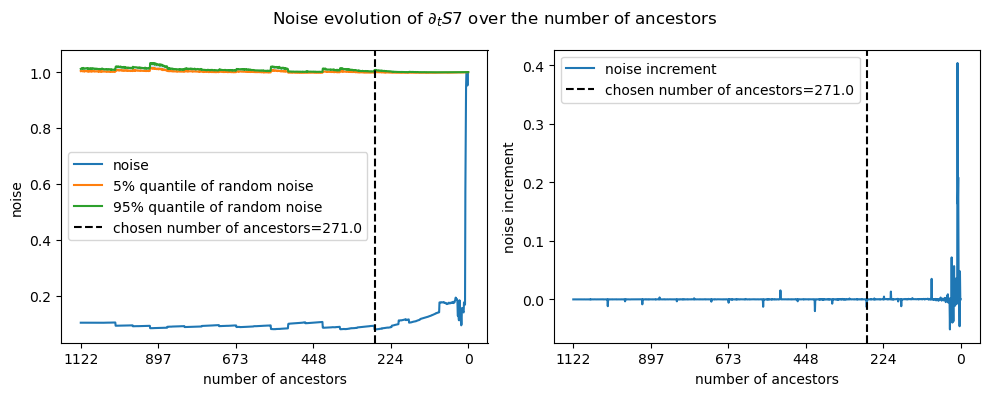

Ancestors of $\partial_t S7$: ['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S10', 'S11', 'S13', 'S14', 'S18', 'S19', 'S20', 'S24', 'S32', 'S34', 'S39', 'S48', 'S57', 'S58', 'S64', 'S70', 'S78', 'S81', 'S83', 'S89', 'S94', 'S95', 'S96', 'S97', 'S104', 'S110', 'S114', 'S115', 'S118', 'S119', 'S122', 'S123', 'S142', 'S143', 'S148', 'S149', 'S150', 'S153', 'S155', 'S158', 'S159', 'S161', 'S163', 'S167', 'S169', 'S171', 'S172', 'S173', 'S174', 'S175', 'S177', 'S180', 'S184', 'S186', 'S190', 'S191', 'S193', 'S194', 'S195', 'S197', 'S203', 'S206', 'S207', 'S208', 'S209', 'S210', 'S212', 'S213', 'S215', 'S218', 'S221', 'S223', 'S224', 'S225', 'S226', 'S229', 'S231', 'S233', 'S236', 'S237', 'S241', 'S242', 'S244', 'S245', 'S246', 'S247', 'S251', 'S255', 'S260', 'S261', 'S265', 'S266', 'S267', 'S269', 'S270', 'S274', 'S275', 'S278', 'S280', 'S283', 'S285', 'S288', 'S292', 'S294', 'S295', 'S299', 'S300', 'S312', 'S313', 'S315', 'S316', 'S321', 'S323', 'S324', 'S327', 'S329', 'S333', 'S337', '

: 

In [62]:
graph_discovery.fit(to_analyze,mode_chooser=mode_chooser)

In [15]:
import glob

files=glob.glob('./results/*.npy')
res={file.split('/')[-1].split('$')[0][:-1]: onp.load(file) for file in files}
res

{'activations': array([[6.57359325e-06, 5.11374699e-04, 5.00507923e-04, ...,
         2.17583333e-05, 3.15197678e-05, 2.00000000e+00],
        [6.57349677e-06, 5.11377644e-04, 5.00510663e-04, ...,
         2.17577944e-05, 3.15192651e-05, 2.00000000e+00],
        [6.57358684e-06, 5.11380296e-04, 5.00513381e-04, ...,
         2.17587411e-05, 3.15150363e-05, 2.00000000e+00],
        ...,
        [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, ...,
         2.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, ...,
         2.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, ...,
         2.00000000e+00, 2.00000000e+00, 2.00000000e+00]]),
 'ancestor_modes': array([[1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ...

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='number of ancestors', ylabel='noise'>)

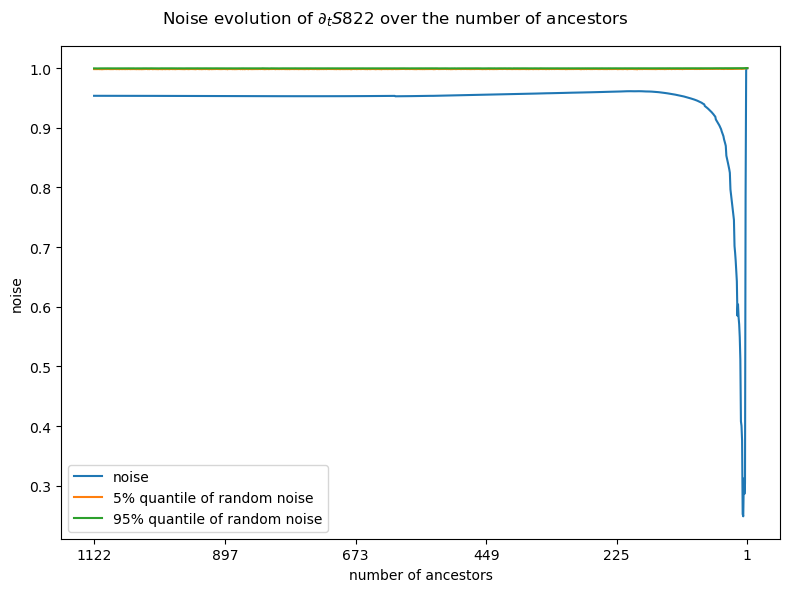

In [16]:
def plot(list_of_noises, list_of_Zs, node_name, ancestor_number, ancestor_modes_number=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(ancestor_number, list_of_noises, label="noise")
    ax.plot(
        ancestor_number,
        [z[0] for z in list_of_Zs],
        label="5% quantile of random noise",
    )
    ax.plot(
        ancestor_number,
        [z[1] for z in list_of_Zs],
        label="95% quantile of random noise",
    )
    # color in between the two lines above
    ax.fill_between(
        ancestor_number,
        [z[0] for z in list_of_Zs],
        [z[1] for z in list_of_Zs],
        alpha=0.2,
    )

    if ancestor_modes_number is not None:
        ax.axvline(
            x=ancestor_modes_number,
            linestyle="--",
            color="k",
            label=f"chosen number of ancestors={ancestor_modes_number}",
        )
    ax.legend()
    ax.set_xlabel("number of ancestors")
    ax.set_ylabel("noise")
    ax.invert_xaxis()
    ax.set_xticks(
        onp.linspace(
            onp.max(ancestor_number),
            onp.min(ancestor_number),
            6,
            dtype=onp.int32,
            endpoint=True,
        )
    )
    # set the title of the whole figure
    fig.suptitle(f"Noise evolution of {node_name} over the number of ancestors")
    fig.tight_layout()
    return fig, ax

inputs={
    'list_of_noises': res['noise_evolution'],
    'list_of_Zs': [(Zl, Zh) for Zl, Zh in zip(res['Z_low_evolution'], res['Z_high_evolution'])],
    'node_name': glob.glob('./results/*.npy')[0][:-4][22:],
    'ancestor_number': [onp.sum(mode) for mode in res['ancestor_modes']],
    'ancestor_modes_number':None,# 48,
}
plot(**inputs)

In [31]:
(res['ancestor_modes'][:,-48]==1)

array([ True,  True,  True, ..., False, False, False])

In [29]:
onp.arange(1122)

array([   0,    1,    2, ..., 1119, 1120, 1121])

In [48]:
res['ancestor_modes'][-48,:-1]
found=set(onp.arange(1122)[res['ancestor_modes'][-50,:-1]==1])

In [11]:
glob.glob('./results/*.npy')[0][:-4][22:]

'$\\partial_t S822$'

In [34]:
true_graph=pickle.load(open('./BCR.pkl','rb'))
true_ancestors = set([int(v[1:]) for v in nx.ancestors(true_graph, glob.glob('./results/*.npy')[0][:-4][22:])])

In [42]:
len(found)

48

In [49]:
found.intersection(true_ancestors)

{4, 792, 822}

In [74]:
pred = graph_discovery.predict(graph_discovery.names[-additional:],df_test.values)

In [75]:
mean_val=onp.mean(df_test[graph_discovery.names[-additional:]].values[:,0])
std_val=onp.std(df_test[graph_discovery.names[-additional:]].values[:,0])
std_val

4490511.974108176

In [76]:
df_test[graph_discovery.names[-additional:]].values[:,0].shape

(2605,)

In [77]:
onp.mean(df_test[graph_discovery.names[-additional:]].values[:,0])

-163480.4667654877

In [78]:
pred

Array([[-6.75477315e-02],
       [-1.24856000e+01],
       [-4.02799541e+00],
       ...,
       [-8.37187059e-03],
       [-8.29650150e-03],
       [-6.71888720e-02]], dtype=float64)

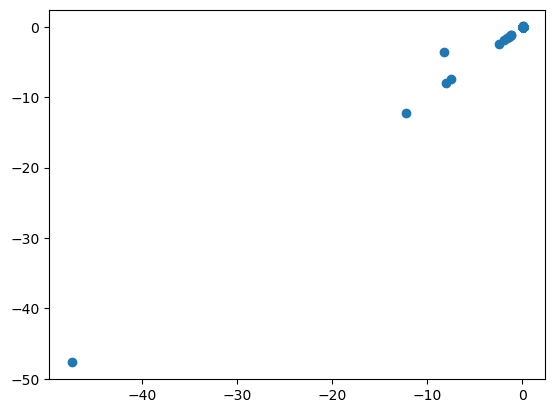

In [79]:
normalized=(df_test[graph_discovery.names[-additional:]].values[:,0]-mean_val)/std_val
normalized_pred=(pred[:,0]-mean_val)/std_val
plt.scatter(normalized,normalized_pred)

(array([2.603e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

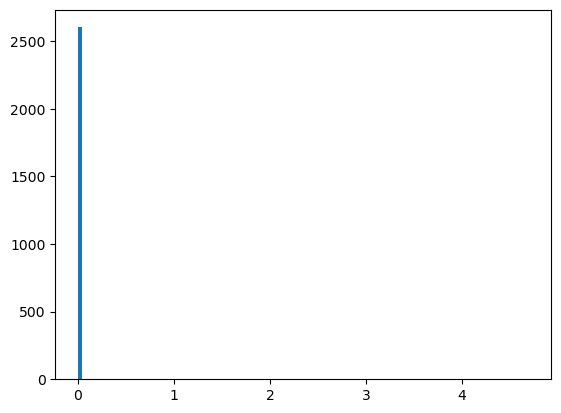

In [86]:
plt.hist(onp.abs(normalized-normalized_pred),bins=100)

In [56]:
graph_discovery.mean_x.shape

(1, 1123)

In [80]:
jax.numpy.argmax(jax.numpy.abs(df_test[graph_discovery.names[-additional:]].values-pred)/std_val)

Array(2120, dtype=int64)

In [81]:
jax.numpy.max(jax.numpy.abs(df_test[graph_discovery.names[-additional:]].values-pred)/std_val)

Array(4.69249256, dtype=float64)

In [82]:
jax.numpy.sum(jax.numpy.abs(df_test[graph_discovery.names[-additional:]].values-pred)/std_val>1e-7)

Array(23, dtype=int64)

In [87]:
jax.numpy.mean(jax.numpy.abs(df_test[graph_discovery.names[-additional:]].values-pred)/std_val)

Array(0.00191738, dtype=float64)

In [83]:
jax.numpy.mean(jax.numpy.abs(df_test[graph_discovery.names[-additional:]].values-pred)**2)/jax.numpy.mean(jax.numpy.abs(df_test[graph_discovery.names[-additional:]].values)**2)

Array(0.00847218, dtype=float64)

In [84]:
noises=jax.random.uniform(jax.random.PRNGKey(0),shape=(1000,))
valid_indices=jax.numpy.where(noises<0.5,jax.numpy.arange(1000),-1)
jax.numpy.max(valid_indices)

Array(997, dtype=int64)

In [ ]:
#get GPU usage
!nvidia-smi

/home/theo/anaconda3/envs/jax-gpu/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Fri May 24 16:30:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-DGXS-32GB           Off |   00000000:07:00.0 Off |                    0 |
| N/A   43C    P0             52W /  300W |   24874MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

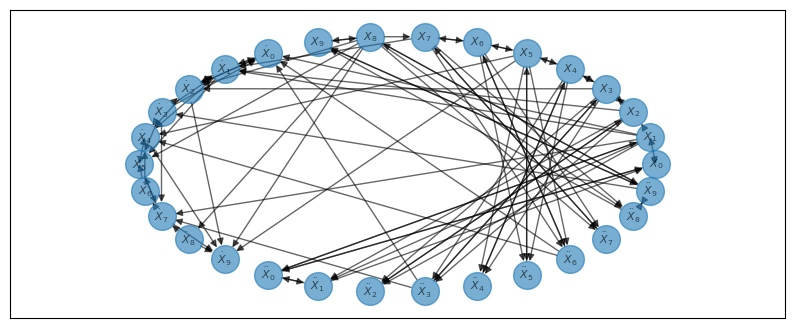

In [ ]:
graph_discovery.plot_graph(type_label=False)

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1549691/3649652240.py:11: SyntaxWarning: invalid escape sequence '\d'
  G2=nx.subgraph(graph_discovery.G,[x for x in graph_discovery.G.nodes() if '\dot' not in x])


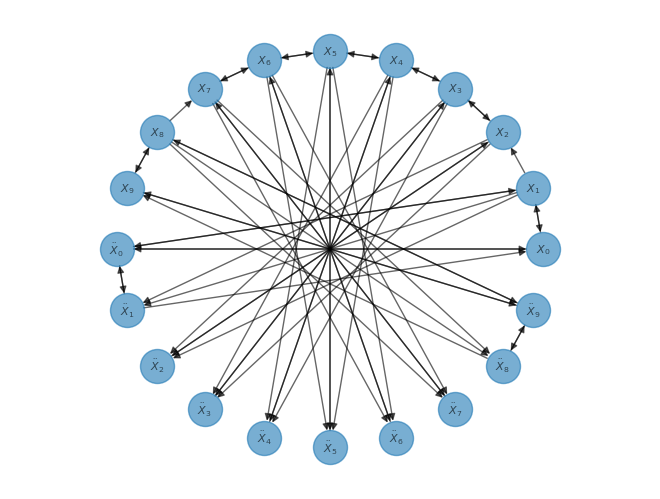

In [ ]:
def plot_a_network(G,type_label=True):
    pos=nx.kamada_kawai_layout(G, G.nodes())
    nx.draw(G, with_labels=True, pos=pos, node_size=600, font_size=8, alpha=0.6)
    if type_label:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'type'))
    x_values, y_values = zip(*pos.values())
    x_max = max(x_values)
    x_min = min(x_values)
    x_margin = (x_max - x_min) * 0.25
    plt.xlim(x_min - x_margin, x_max + x_margin)
G2=nx.subgraph(graph_discovery.G,[x for x in graph_discovery.G.nodes() if '\dot' not in x])
plot_a_network(G2,type_label=False)

# Non-Linear FPUT

In [ ]:
df_non_linear=pd.read_csv('./examples/FPUT_non_linear.csv')
df_non_linear

,$X_{0}$,$X_{1}$,$X_{2}$,$X_{3}$,$X_{4}$,$X_{5}$,$X_{6}$,$X_{7}$,$X_{8}$,$X_{9}$,...,$\ddot{X}_{0}$,$\ddot{X}_{1}$,$\ddot{X}_{2}$,$\ddot{X}_{3}$,$\ddot{X}_{4}$,$\ddot{X}_{5}$,$\ddot{X}_{6}$,$\ddot{X}_{7}$,$\ddot{X}_{8}$,$\ddot{X}_{9}$
0,-0.353162,-0.027925,-0.060415,0.151765,0.010142,0.243446,-0.032991,-0.229524,0.236459,0.039009,...,54.993213,-31.459180,20.458112,-28.800655,30.624385,-41.365914,7.920080,57.560078,-57.613237,13.551324
1,0.181612,-0.040168,0.039506,-0.350263,-0.356168,-0.296971,-0.066569,-0.422200,-0.463840,-0.316946,...,-32.727555,24.910978,-41.681386,35.960815,5.288329,15.030604,-48.213101,29.447335,15.440301,16.737826
2,0.181387,0.689829,0.177607,0.247176,0.169467,0.147400,0.475722,-0.171927,0.315934,-0.125602,...,39.097769,-82.674935,56.358749,-11.930256,4.551912,31.043421,-87.114628,94.324581,-75.442681,50.523425
3,0.108495,-0.263442,0.085607,-0.526893,0.126317,0.168490,0.072781,0.313828,-0.278529,-0.107404,...,-41.615858,58.430547,-83.291167,102.692317,-73.427018,-11.200548,27.853479,-75.837294,72.815185,-5.561878
4,0.318325,-0.155868,0.214159,-0.362474,0.136723,0.003964,-0.052347,0.296391,-0.269704,-0.238277,...,-65.753482,69.123741,-79.952551,87.664703,-58.061758,6.413550,35.614576,-77.602247,62.235105,17.973559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.097388,-0.362862,0.124927,-0.376848,0.182781,-0.472934,0.278333,-0.110748,0.436868,0.170341,...,-51.115928,76.849319,-80.170319,86.261473,-99.351720,115.006100,-104.485005,77.779434,-71.155972,9.277894
996,0.055470,0.181867,0.204995,-0.480468,0.468355,-0.078220,0.418435,-0.173228,0.204591,-0.434794,...,5.935058,-8.551795,-82.574678,141.558568,-140.725955,84.712117,-88.949437,82.119032,-88.030636,90.650482
997,-0.058144,-0.165295,0.084218,-0.186435,0.401695,-0.367180,0.221276,-0.259655,0.445895,0.175709,...,-4.077966,29.475257,-42.152234,76.572594,-113.508261,113.522602,-87.621847,100.953804,-94.014955,9.174123
998,-0.057468,0.207577,-0.074452,-0.340633,-0.011811,0.110838,-0.188654,-0.131314,0.067691,-0.305993,...,27.249219,-44.325810,1.669535,48.384258,-20.103760,-35.262866,30.598250,12.228902,-47.803172,55.306065


In [ ]:

graph_discovery_non_linear=CHD.GraphDiscovery.from_dataframe(df_non_linear,normalize=True)

new result yb=[-1.65965325e-10  6.80017778e-10  1.15366466e-09 -3.07004211e-10
 -4.07405985e-10 -1.54217424e-09  3.40053689e-10  4.87099043e-10
  6.72135782e-10  2.72820685e-11], noise=0.16866431190172018
new result yb=[-1.34093549e-09  6.21599034e-10  2.51242083e-10  4.24214953e-10
 -8.34440583e-10 -3.15869166e-11 -1.16591063e-10 -3.74867105e-11
  4.55843778e-10 -6.22166389e-10], noise=0.19332086372968665
new result yb=[-1.85077526e-10  6.04373678e-10 -8.05830896e-10  1.02330784e-09
  9.94952520e-10  6.79080765e-10 -1.35985149e-09 -1.03568515e-09
 -5.76267804e-10 -1.12074669e-09], noise=0.16913414417640515
original result yb=[ 6.64063860e-10 -2.79162166e-10  9.40227223e-10 -8.99818277e-10
 -8.42853620e-10 -6.75277305e-10  9.27729633e-10  1.23679158e-09
  7.50210141e-10  8.07266623e-10], noise=0.16891912908847026, Z=(0.25290708017418745,0.30157051194624623)
new result yb=[-1.36962041e-10  1.10850634e-09 -5.18474939e-10 -2.92268209e-10
 -3.71346700e-10  5.91148809e-11  6.46118646e-10 -1

Finding ancestors with kernel [gaussian]:   4%|▎         | 1/28 [00:01<00:32,  1.19s/it]

new result yb=[ 1.80859597e-10 -1.37668142e-09 -6.41425984e-10 -5.14418685e-10
  5.81513926e-10  3.32909300e-10 -1.46471238e-10 -1.92363317e-10
 -3.15520525e-10  7.75557635e-10], noise=0.19732690070085154
original result yb=[-7.26213333e-10  8.85459851e-10 -4.84031413e-10 -4.92209759e-10
  4.87885206e-11  1.06641348e-09  3.15084054e-11 -6.16521031e-11
 -1.03828040e-10  4.10282264e-10], noise=0.18552599685037874, Z=(0.2621718349502859,0.2979101190150926)
original result yb=[-7.27160424e-10  5.38683995e-10 -5.79141526e-10  6.04487564e-10
  9.28947108e-10  4.66029918e-10 -9.02368132e-11 -8.27228565e-10
  1.37439165e-10 -1.33548446e-10], noise=0.17243346411523383, Z=(0.25929085320435646,0.31308191952840403)
original result yb=[-1.12609253e-09  1.12777122e-09 -2.24652533e-10  9.65504459e-10
 -8.73194445e-10  2.27054812e-10  3.84435973e-10 -3.66658339e-10
  8.23735606e-10 -1.49033469e-10], noise=0.19541997778559247, Z=(0.2606173822321752,0.3120478161554861)
original result yb=[-5.57056573e-1

Finding ancestors with kernel [gaussian]:   7%|▋         | 2/28 [00:02<00:30,  1.19s/it]

new result yb=[ 1.74205100e-10 -1.35129829e-09 -6.25181071e-10 -5.04640944e-10
  5.79309831e-10  3.31152259e-10 -1.32067863e-10 -1.95944839e-10
 -2.81088768e-10  7.57415505e-10], noise=0.2085784982421462
original result yb=[-6.95876652e-10  8.53663230e-10 -4.75807314e-10 -4.89880920e-10
  3.88223588e-11  1.04403927e-09  2.77728503e-11 -7.05519985e-11
 -1.05049896e-10  3.85408507e-10], noise=0.19443183603300196, Z=(0.275219171364068,0.3223688633584677)
original result yb=[-6.58240196e-10  5.19328655e-10 -5.65759214e-10  5.53808367e-10
  8.67520521e-10  4.51122830e-10 -7.58910695e-11 -7.84778550e-10
  1.57199293e-10 -1.02894476e-10], noise=0.17772734645856533, Z=(0.2720561692447835,0.3196361625905374)
original result yb=[-1.08582861e-09  1.08725440e-09 -2.26163121e-10  9.32632867e-10
 -8.59914274e-10  2.39706888e-10  3.68263177e-10 -3.64601349e-10
  7.93087576e-10 -1.43772306e-10], noise=0.20536536395227534, Z=(0.2765882337635776,0.3239227541242211)
original result yb=[-5.20341982e-10  9

Finding ancestors with kernel [gaussian]:  11%|█         | 3/28 [00:03<00:29,  1.19s/it]

new result yb=[ 1.48430483e-10 -1.32096008e-09 -6.14487712e-10 -5.14835950e-10
  5.73435579e-10  3.26010885e-10 -1.15839534e-10 -1.83640155e-10
 -2.81067858e-10  7.71485667e-10], noise=0.22038046945912976
original result yb=[-6.52535025e-10  8.12919499e-10 -4.66670943e-10 -4.93246778e-10
  3.80801903e-11  1.02978411e-09  2.87792913e-11 -7.74081548e-11
 -1.11149733e-10  3.63240683e-10], noise=0.2047094260136928, Z=(0.2968969909387599,0.3386095934411028)
original result yb=[-6.23787717e-10  4.72249192e-10 -5.46624033e-10  5.14664654e-10
  8.02431407e-10  4.38826390e-10 -5.97744578e-11 -7.43772935e-10
  1.48930201e-10 -3.91360737e-11], noise=0.18507482285771482, Z=(0.29529534284379755,0.336848674388076)
original result yb=[-1.03900791e-09  1.02609370e-09 -2.20701496e-10  8.88581590e-10
 -8.40079485e-10  2.44885047e-10  3.62840349e-10 -3.45330623e-10
  7.64322084e-10 -1.44507310e-10], noise=0.2241031894439276, Z=(0.3025390376518392,0.34663808499131316)
original result yb=[-4.84172847e-10  

Finding ancestors with kernel [gaussian]:  14%|█▍        | 4/28 [00:04<00:28,  1.19s/it]

new result yb=[ 1.38183462e-10 -1.27218448e-09 -6.01983063e-10 -4.82022840e-10
  5.35616154e-10  3.26600509e-10 -1.07536176e-10 -2.00806075e-10
 -2.50688245e-10  7.71625915e-10], noise=0.23649295500741874
original result yb=[-6.07363027e-10  7.83825214e-10 -4.49117597e-10 -4.69975507e-10
  3.06063767e-11  9.96801919e-10  2.55222965e-11 -7.59626421e-11
 -1.19646361e-10  3.12938678e-10], noise=0.21786719087884365, Z=(0.3220274309120155,0.3593038873980539)
original result yb=[-5.82359704e-10  4.44549742e-10 -5.34162370e-10  4.71076409e-10
  7.35750310e-10  4.30672851e-10 -6.09690684e-11 -6.86082450e-10
  1.51288625e-10 -3.26907476e-11], noise=0.19327074307168693, Z=(0.31289841608322533,0.35309367459373503)
original result yb=[-1.00004249e-09  9.88912771e-10 -2.22395635e-10  8.41166790e-10
 -8.10001976e-10  2.27517621e-10  3.28135073e-10 -3.19917969e-10
  7.31081160e-10 -1.49713502e-10], noise=0.2423003775052986, Z=(0.3224560700210077,0.3649938269386125)
original result yb=[-4.30361247e-10

Finding ancestors with kernel [gaussian]:  18%|█▊        | 5/28 [00:05<00:27,  1.19s/it]

new result yb=[ 1.51408443e-10 -1.17603789e-09 -5.82152332e-10 -4.32109158e-10
  5.14604551e-10  3.15265646e-10 -1.38932614e-10 -2.16062050e-10
 -2.40888916e-10  8.05209582e-10], noise=0.2641408446753137
original result yb=[-5.10146315e-10  7.35437511e-10 -4.34577939e-10 -4.46222748e-10
  1.53422549e-11  9.62732181e-10  3.30839461e-11 -8.06568129e-11
 -1.38777398e-10  3.06294601e-10], noise=0.23639537480351316, Z=(0.3538214444981214,0.3906164321686532)
original result yb=[-5.46399656e-10  3.99417586e-10 -5.10008680e-10  4.47992366e-10
  6.82904237e-10  4.18881640e-10 -2.65424344e-11 -6.42784189e-10
  1.35850038e-10 -2.82641024e-11], noise=0.2074288160442541, Z=(0.3456694178563149,0.37969377204659727)
original result yb=[-8.90476158e-10  9.33075745e-10 -2.18793967e-10  8.19028062e-10
 -7.88454371e-10  2.23615446e-10  3.08075984e-10 -2.96967697e-10
  6.43912126e-10 -1.42288600e-10], noise=0.27009439539558594, Z=(0.36129508191570464,0.39587194801624703)
original result yb=[-3.95860752e-10

Finding ancestors with kernel [gaussian]:  21%|██▏       | 6/28 [00:07<00:26,  1.20s/it]

new result yb=[ 8.96186249e-11 -1.08287257e-09 -5.65646457e-10 -3.48312157e-10
  5.21447737e-10  2.95095534e-10 -1.48920102e-10 -2.06843879e-10
 -2.37072630e-10  7.92794903e-10], noise=0.2776446523797954
original result yb=[-4.30299134e-10  6.69394145e-10 -4.10866988e-10 -4.26593108e-10
  3.70863906e-11  9.10469334e-10  3.71168829e-11 -7.44349739e-11
 -1.33108811e-10  2.99124605e-10], noise=0.2540553165403597, Z=(0.3875533966181525,0.4216102396553276)
original result yb=[-4.54545970e-10  3.68537298e-10 -4.97117412e-10  3.84894169e-10
  6.20643197e-10  3.94408180e-10 -1.51894687e-11 -6.16448648e-10
  1.17023016e-10  1.70468909e-11], noise=0.21888098397096034, Z=(0.37153004677932916,0.4043970631045555)
original result yb=[-7.86302581e-10  8.98954806e-10 -2.05894462e-10  8.17287777e-10
 -7.92289024e-10  2.24590561e-10  2.86232560e-10 -2.83980695e-10
  6.24259230e-10 -1.76743934e-10], noise=0.2971826699460007, Z=(0.3958954758770472,0.42868906872081697)
original result yb=[-3.61194834e-10  

Finding ancestors with kernel [gaussian]:  25%|██▌       | 7/28 [00:08<00:25,  1.19s/it]

new result yb=[ 1.05899387e-10 -1.01320897e-09 -5.43361758e-10 -3.15590725e-10
  5.29380126e-10  2.95923914e-10 -1.41059450e-10 -2.33296101e-10
 -2.01372917e-10  7.57827599e-10], noise=0.2917450077949544
original result yb=[-3.89086501e-10  6.05809299e-10 -3.86897445e-10 -4.09329629e-10
  5.40960867e-11  8.73189130e-10  3.96992088e-11 -6.21443961e-11
 -1.26197054e-10  2.92153389e-10], noise=0.26561328726597827, Z=(0.4207304428018447,0.45254693596390577)
original result yb=[-4.22344390e-10  3.37651333e-10 -4.72852924e-10  3.51066479e-10
  5.68548586e-10  3.62656230e-10 -1.83081690e-11 -5.59769754e-10
  1.09738220e-10  2.85348983e-11], noise=0.23427553506224238, Z=(0.4106865875096374,0.44559195978502886)
original result yb=[-7.38118313e-10  8.45784965e-10 -2.04498788e-10  7.79006779e-10
 -7.78208918e-10  2.21164051e-10  2.64608876e-10 -2.97250507e-10
  6.11976071e-10 -1.69178114e-10], noise=0.312028889252884, Z=(0.4164016868833005,0.4461055961844819)
original result yb=[-3.30453021e-10  

Finding ancestors with kernel [gaussian]:  29%|██▊       | 8/28 [00:09<00:23,  1.19s/it]

new result yb=[ 6.27635584e-11 -9.16962058e-10 -5.24158013e-10 -3.07460646e-10
  5.15097071e-10  2.84560173e-10 -1.29226997e-10 -2.43334755e-10
 -1.94172060e-10  7.41172613e-10], noise=0.30644922639367994
original result yb=[-3.58204910e-10  5.55050167e-10 -3.51168673e-10 -3.94463450e-10
  4.82384137e-11  8.47002061e-10  3.89661527e-11 -5.30061511e-11
 -1.17875480e-10  2.91616204e-10], noise=0.2711182914828672, Z=(0.4504826906128503,0.4764943635773806)
original result yb=[-3.55617167e-10  3.12790147e-10 -4.59856523e-10  3.00138993e-10
  5.23831485e-10  3.50420680e-10  1.31617458e-11 -5.25578517e-10
  9.54798624e-11  1.94365951e-11], noise=0.24286478784339768, Z=(0.44102698180542205,0.47389852374028135)
original result yb=[-7.31163351e-10  8.03850051e-10 -1.96554065e-10  7.42169756e-10
 -7.54056632e-10  2.09076219e-10  2.54696114e-10 -2.39285394e-10
  5.23712234e-10 -1.49663506e-10], noise=0.32812820827426536, Z=(0.43663354971506624,0.4669995452154782)
original result yb=[-3.20441426e-1

Finding ancestors with kernel [gaussian]:  32%|███▏      | 9/28 [00:10<00:22,  1.19s/it]

new result yb=[ 3.60532299e-11 -8.84226962e-10 -5.05973584e-10 -2.95363037e-10
  4.91082353e-10  2.51291475e-10 -1.13331172e-10 -2.27071181e-10
 -2.07572322e-10  7.56931400e-10], noise=0.31745025076015054
original result yb=[-3.69849098e-10  5.30264620e-10 -3.13175159e-10 -4.13403588e-10
  5.05731973e-11  8.37686582e-10  4.50835561e-11 -3.54194436e-11
 -7.45675352e-11  2.57195274e-10], noise=0.27057454891952065, Z=(0.47330236029358147,0.5014811298271885)
original result yb=[-2.93840359e-10  2.82835212e-10 -4.51289789e-10  2.71144805e-10
  4.90872097e-10  3.00795164e-10  3.84343161e-11 -4.94627557e-10
  1.01168784e-10  4.18885644e-11], noise=0.24158124054782495, Z=(0.45994929372208226,0.48908313763542677)
original result yb=[-6.97953233e-10  7.71507922e-10 -2.01182454e-10  7.05583029e-10
 -7.41856800e-10  1.96595223e-10  2.23875274e-10 -2.52456380e-10
  4.74557639e-10 -1.57750431e-10], noise=0.3399509761946306, Z=(0.4538004117551,0.48323636110735446)
original result yb=[-3.09575255e-10 

Finding ancestors with kernel [gaussian]:  36%|███▌      | 10/28 [00:11<00:21,  1.19s/it]

new result yb=[ 2.77429094e-11 -7.90517577e-10 -4.83572921e-10 -2.81504728e-10
  4.84650273e-10  2.27214847e-10 -9.52781237e-11 -2.37230068e-10
 -2.12775168e-10  7.42223450e-10], noise=0.3312706713779456
original result yb=[-3.38947129e-10  5.05482274e-10 -2.99183247e-10 -3.88096414e-10
  4.58950292e-11  8.30176175e-10  4.88570262e-11 -4.22296135e-11
 -8.75772337e-11  2.38972964e-10], noise=0.26539872203436604, Z=(0.4882375248285758,0.5186885982484175)
original result yb=[-2.68054102e-10  2.36419287e-10 -4.45340897e-10  2.63429519e-10
  4.71483307e-10  2.90700593e-10  5.48510551e-11 -3.88607026e-10
  9.89725464e-11  6.32741599e-11], noise=0.23930827585073203, Z=(0.47844795073514057,0.5020117365633583)
original result yb=[-7.09997073e-10  7.78134869e-10 -2.11100302e-10  6.74524033e-10
 -7.31019109e-10  1.69464114e-10  1.83933673e-10 -2.57259335e-10
  4.03249507e-10 -1.65800122e-10], noise=0.3546563342354512, Z=(0.4728483404382068,0.5050802652206353)
original result yb=[-3.20628339e-10  

Finding ancestors with kernel [gaussian]:  39%|███▉      | 11/28 [00:13<00:20,  1.19s/it]

new result yb=[-6.59638571e-11 -7.54315835e-10 -4.65237887e-10 -2.86965556e-10
  5.00175838e-10  2.21500080e-10 -3.92270116e-11 -2.39407176e-10
 -2.00923416e-10  7.41378424e-10], noise=0.3419344528154423
original result yb=[-2.93123903e-10  4.62542122e-10 -2.88965091e-10 -3.99616191e-10
  8.00128724e-11  8.05843512e-10  4.23533015e-11 -4.22453845e-11
 -6.25155075e-11  2.34707124e-10], noise=0.2573858185078616, Z=(0.5028989868665,0.5283296844417413)
original result yb=[-2.58509385e-10  2.20058846e-10 -4.36843455e-10  2.31339531e-10
  4.53776758e-10  2.15854565e-10  7.10693508e-11 -3.67102228e-10
  9.02040349e-11  1.23829556e-10], noise=0.234096983161845, Z=(0.4934055660933702,0.5242361240052615)
original result yb=[-7.16503239e-10  7.30334857e-10 -2.27825115e-10  6.56875600e-10
 -7.64372214e-10  1.94218804e-10  1.72623866e-10 -2.62207516e-10
  3.87943551e-10 -1.69788057e-10], noise=0.36846108338872907, Z=(0.49574436246665654,0.52455197997728)
original result yb=[-3.08985503e-10  5.27252

Finding ancestors with kernel [gaussian]:  43%|████▎     | 12/28 [00:14<00:19,  1.19s/it]

new result yb=[-5.62595771e-11 -7.02151504e-10 -4.38715205e-10 -2.39766024e-10
  5.29418909e-10  2.28939494e-10 -4.57785646e-11 -2.96872418e-10
 -1.74502794e-10  7.27274399e-10], noise=0.3514556445048411
original result yb=[-2.59546615e-10  4.41625989e-10 -2.86942432e-10 -4.03331038e-10
  1.24603282e-10  7.75069803e-10  2.82844502e-12 -6.73832469e-11
 -7.28079115e-11  2.49435902e-10], noise=0.24700467937224702, Z=(0.521981639446989,0.5459698213775909)
original result yb=[-2.09289932e-10  2.14743101e-10 -4.35595905e-10  2.21253386e-10
  4.31429519e-10  2.07412442e-10  7.47504508e-11 -3.09186246e-10
  9.29279855e-11  1.38151253e-10], noise=0.22733704135487148, Z=(0.5080538560227734,0.5362309678947264)
original result yb=[-6.85209432e-10  7.34272561e-10 -2.36246519e-10  6.46360491e-10
 -7.91231264e-10  1.94140740e-10  1.46156967e-10 -2.47910087e-10
  3.92216237e-10 -1.75300571e-10], noise=0.37547929850269673, Z=(0.5052571363295311,0.5331422006699899)
original result yb=[-3.07064559e-10  4

Finding ancestors with kernel [gaussian]:  46%|████▋     | 13/28 [00:15<00:17,  1.19s/it]

new result yb=[-9.83755647e-11 -6.87492358e-10 -4.39418020e-10 -1.49512538e-10
  5.72750182e-10  2.47803133e-10 -3.51893170e-11 -3.04252365e-10
 -1.54731686e-10  7.41561678e-10], noise=0.3625031803978748
original result yb=[-2.36766013e-10  3.07310787e-10 -2.65200175e-10 -4.14034817e-10
  1.05317574e-10  7.75663777e-10  1.74248161e-11 -5.58339101e-11
 -7.94723456e-11  2.33825265e-10], noise=0.2332300542849587, Z=(0.5278939873605198,0.5629230876083228)
original result yb=[-1.88890358e-10  2.06814672e-10 -4.27259158e-10  2.13486593e-10
  4.34806724e-10  1.55880341e-10  8.16234526e-11 -2.75258956e-10
  9.47038704e-11  1.64686527e-10], noise=0.21915836375168393, Z=(0.5227828515651359,0.5500492491528984)
original result yb=[-7.04256566e-10  7.38972017e-10 -2.46772750e-10  6.40737205e-10
 -7.83220787e-10  1.92858369e-10  1.35180745e-10 -2.27863964e-10
  3.98704825e-10 -1.67445116e-10], noise=0.38441022516463497, Z=(0.5150917294943919,0.544589806939148)
original result yb=[-2.96075651e-10  3.

Finding ancestors with kernel [gaussian]:  50%|█████     | 14/28 [00:16<00:16,  1.19s/it]

new result yb=[-2.27376625e-10 -6.93821767e-10 -4.37088154e-10 -1.01139799e-10
  5.85293735e-10  2.56596180e-10 -6.97299605e-11 -2.70248392e-10
 -9.82948699e-11  7.76995537e-10], noise=0.373691061561497
original result yb=[-2.09896500e-10  2.71249980e-10 -2.42899637e-10 -3.89478272e-10
  1.06390146e-10  7.70175431e-10 -5.04146178e-12 -4.53689615e-11
 -8.09648537e-11  2.08942502e-10], noise=0.22044839454213436, Z=(0.5508249421833065,0.5800106201625539)
original result yb=[-1.68673036e-10  1.99883607e-10 -4.39088238e-10  1.85617124e-10
  4.15701240e-10  1.43384813e-10  9.70031340e-11 -1.70766257e-10
  1.01202442e-10  1.81381951e-10], noise=0.2069044616536718, Z=(0.5419497273314304,0.574083226323879)
original result yb=[-7.15544728e-10  7.55043748e-10 -3.13159717e-10  6.35303272e-10
 -7.91143366e-10  1.85103198e-10  1.55363190e-10 -2.10709906e-10
  3.91133771e-10 -1.54141260e-10], noise=0.40060169884490265, Z=(0.5351475703200025,0.5608598138427254)
original result yb=[-2.76924514e-10  3.4

Finding ancestors with kernel [gaussian]:  54%|█████▎    | 15/28 [00:17<00:15,  1.19s/it]

new result yb=[-2.91936115e-10 -6.68740919e-10 -4.15075783e-10 -5.88577113e-11
  6.34584725e-10  2.50198405e-10  8.00794742e-11 -2.95701236e-10
 -7.05131050e-11  8.30463317e-10], noise=0.3870991552759253
original result yb=[-1.78330986e-10  2.60985716e-10 -1.97868916e-10 -4.00094827e-10
  1.21890731e-10  7.57369817e-10  4.77513925e-12 -4.45653507e-11
 -7.91815011e-11  1.99928424e-10], noise=0.2070433221747427, Z=(0.5590307664019427,0.5906216474145178)
original result yb=[-1.32625070e-10  1.85580631e-10 -4.63219574e-10  1.51658841e-10
  3.59877507e-10  1.25074150e-10  1.24806997e-10 -3.72966883e-11
  1.25303763e-10  1.90360631e-10], noise=0.19490082552587665, Z=(0.556100068364649,0.5895499884882145)
original result yb=[-7.66241141e-10  7.29073614e-10 -3.05096716e-10  6.92838287e-10
 -8.55430740e-10  2.16647488e-10  1.69560351e-10 -2.08874790e-10
  3.96942909e-10 -1.51145850e-10], noise=0.41230397777151684, Z=(0.5502460338060853,0.5769333847209666)
original result yb=[-2.37702142e-10  3.

Finding ancestors with kernel [gaussian]:  57%|█████▋    | 16/28 [00:19<00:14,  1.19s/it]

new result yb=[-3.04551836e-10 -6.82072334e-10 -3.88558612e-10  4.37048601e-12
  6.63089303e-10  2.57892258e-10  2.98171996e-11 -2.55684582e-10
 -2.09631933e-11  8.94802922e-10], noise=0.40206118108917144
original result yb=[-1.46091151e-10  2.68656587e-10 -1.39634599e-10 -4.30700216e-10
  1.32031927e-10  7.74706283e-10 -1.23008311e-11 -5.18173015e-11
 -7.17315663e-11  1.69208431e-10], noise=0.1913320843400901, Z=(0.57310618403076,0.60389277099437)
original result yb=[-1.02008822e-10  1.82562983e-10 -4.60758223e-10  1.00059120e-10
  2.64980599e-10  1.23050839e-10  1.48824577e-10 -1.42603677e-11
  1.39287869e-10  2.34453533e-10], noise=0.17766400218360212, Z=(0.5735585373532955,0.6063606976273409)
original result yb=[-8.60869975e-10  7.49449456e-10 -3.26638080e-10  6.28226003e-10
 -9.04883002e-10  2.64955158e-10  1.61188932e-10 -2.53146412e-10
  3.75613096e-10 -1.34211597e-10], noise=0.4299219478938405, Z=(0.5648831823405781,0.5943048535781678)
original result yb=[-1.97241755e-10  4.266

Finding ancestors with kernel [gaussian]:  61%|██████    | 17/28 [00:20<00:13,  1.19s/it]

new result yb=[-3.33836998e-10 -6.31630612e-10 -6.54119682e-11  2.74529796e-10
  7.95961290e-10  2.98803178e-10 -9.53306530e-11 -2.62678643e-10
 -8.52805879e-13  9.46663238e-10], noise=0.4215262494932606
original result yb=[-8.21670108e-11  2.23905293e-10 -9.25106196e-11 -4.36570296e-10
  1.55940362e-10  8.11825270e-10 -4.05962004e-11 -6.14009958e-11
 -8.48682186e-11  1.54972344e-10], noise=0.17364859934471186, Z=(0.5920191885191636,0.6276814129074537)
original result yb=[-5.86834684e-11  1.25334613e-10 -4.66585204e-10  5.34387558e-11
  2.15561063e-10  1.13607283e-10  1.45347102e-10  1.73231292e-11
  1.41160295e-10  2.10755308e-10], noise=0.16291273465192044, Z=(0.5874860118004096,0.621846417446204)
original result yb=[-8.84990945e-10  7.92379944e-10 -3.54506656e-10  6.63830700e-10
 -9.28824604e-10  2.80229319e-10  1.39236842e-10 -2.51075379e-10
  3.74206668e-10 -1.76669319e-10], noise=0.4411717688507, Z=(0.5711993574954699,0.5968040975598312)
original result yb=[-1.87882311e-10  4.364

Finding ancestors with kernel [gaussian]:  64%|██████▍   | 18/28 [00:21<00:11,  1.19s/it]

new result yb=[-4.29725557e-10 -5.94547633e-10 -1.05330007e-10  2.95882096e-10
  8.21104256e-10  3.06178957e-10 -1.66610080e-10 -2.01226500e-10
 -9.40093531e-12  9.54726967e-10], noise=0.4331761778809324
original result yb=[ 1.40519670e-10  4.47882841e-11 -6.63916762e-11 -5.33052347e-10
  1.00604444e-10  8.75512014e-10 -1.44544757e-11 -5.53725369e-11
 -6.90676464e-12  1.48760401e-10], noise=0.14468983877561578, Z=(0.6210990944690722,0.6518509036604367)
original result yb=[-5.22949091e-11  7.93052160e-11 -4.42005627e-10  3.73118533e-11
  1.45168024e-10  4.66032516e-11  1.34976704e-10  1.02641120e-10
  1.26700884e-10  1.57103370e-10], noise=0.14549455113783788, Z=(0.6040998082781203,0.6377115133510324)
original result yb=[-9.37045513e-10  7.81507743e-10 -4.17663371e-10  7.18614096e-10
 -1.00602108e-09  3.99556870e-10  1.40986642e-10 -2.42823521e-10
  4.11535297e-10 -1.90371282e-10], noise=0.46207419814765605, Z=(0.581583014866278,0.6137955672538126)
original result yb=[-1.86208330e-10  3

Finding ancestors with kernel [gaussian]:  68%|██████▊   | 19/28 [00:22<00:10,  1.19s/it]

new result yb=[-5.42698000e-10 -6.03265149e-10 -5.39727082e-11  2.77545336e-10
  8.95239244e-10  3.30915568e-10 -2.09864750e-10 -1.73114878e-10
  2.76676600e-11  1.01565673e-09], noise=0.44868040086922517
original result yb=[ 2.81606902e-10  5.08027202e-11 -5.40142799e-12 -5.98125481e-10
  1.20978095e-10  9.54816647e-10 -9.46253222e-11 -6.90462423e-11
  1.13607657e-10  1.79260081e-10], noise=0.10401767079250838, Z=(0.6572250618366606,0.6957845090946079)
original result yb=[ 9.46830568e-11 -2.79881545e-11 -4.38860726e-10  6.22257192e-11
  1.15116475e-10  5.40511765e-11  1.47908511e-10  1.03520888e-10
  1.27090842e-10  1.54000691e-10], noise=0.1301280522143179, Z=(0.6237943911672557,0.6561443227854762)
original result yb=[-1.16618277e-09  8.44150608e-10 -5.29444605e-10  7.30938707e-10
 -1.11029536e-09  3.68255486e-10  3.17757537e-10 -2.73693308e-10
  4.04858386e-10 -1.92826061e-10], noise=0.4832946927379228, Z=(0.5960358071833844,0.6231612457100574)
original result yb=[-1.07128048e-10  3

Finding ancestors with kernel [gaussian]:  71%|███████▏  | 20/28 [00:23<00:09,  1.19s/it]

new result yb=[-9.28712339e-10 -6.96978329e-10  5.75074226e-11  2.67881370e-10
  1.06707613e-09  5.37276679e-10 -2.91362592e-10 -1.86786189e-10
  3.15922075e-11  1.20597321e-09], noise=0.48254807714091225
original result yb=[ 4.52425254e-10 -1.63763374e-10 -7.31541738e-11 -6.44591734e-10
  1.44743656e-10  9.92471599e-10  1.97903503e-11 -3.22442992e-11
  3.00209727e-10  2.55692663e-10], noise=0.08254460442853272, Z=(0.6822414755416877,0.7208020181565667)
original result yb=[ 1.33184779e-10 -8.10954041e-11 -4.31274702e-10 -8.79226290e-12
 -9.13906806e-11  6.18791788e-11  1.23175053e-10  9.48206299e-11
  7.75764925e-11  4.34984446e-11], noise=0.10968730421294369, Z=(0.6433645439387681,0.6769552417007177)
original result yb=[-1.49775389e-09  8.02993327e-10 -6.16429465e-10  8.03629782e-10
 -1.24035307e-09  4.09043830e-10  3.72249454e-10 -3.60876400e-10
  2.91706494e-10 -2.12554054e-10], noise=0.5149075206406143, Z=(0.6127491913575931,0.6443696139093373)
original result yb=[-2.38142383e-10  

Finding ancestors with kernel [gaussian]:  75%|███████▌  | 21/28 [00:25<00:08,  1.19s/it]

new result yb=[-1.67856058e-09 -7.67742289e-10  2.38914403e-10  3.70775324e-10
  1.34226983e-09  3.37040726e-10 -1.71268300e-09 -6.62491268e-10
 -2.45306430e-10  1.43601908e-09], noise=0.5432995937905268
original result yb=[ 5.17896915e-10 -2.24077135e-10  2.76252665e-10 -8.76864507e-10
  2.37652380e-10  8.37627544e-10  7.67649517e-11 -1.59394352e-10
  1.39123430e-10  3.07218842e-11], noise=0.06539262554161465, Z=(0.7166886558454453,0.756431915307191)
original result yb=[ 2.39380960e-10 -1.89142651e-10 -4.14616973e-10 -2.60178527e-11
 -1.63088030e-10  1.16102387e-10  9.98615123e-11  3.42503810e-11
 -4.39586487e-11 -4.53611362e-11], noise=0.08920340219136191, Z=(0.6695252794631515,0.7087622991823552)
original result yb=[-1.71297057e-09  9.63465917e-10 -7.94369178e-10  1.32179087e-09
 -2.05876327e-09  5.23629452e-10  4.68134814e-10 -3.59501577e-10
  5.12228475e-10 -3.83479200e-10], noise=0.5716051158889089, Z=(0.6383512417551978,0.6692843964508233)
original result yb=[-7.86192037e-10  2.

Finding ancestors with kernel [gaussian]:  79%|███████▊  | 22/28 [00:26<00:07,  1.19s/it]

new result yb=[-2.31486894e-09 -1.54665774e-09  5.60430945e-10  4.88187824e-10
  2.19087500e-09  1.74160352e-10 -3.49670893e-09 -1.97367146e-09
  1.44213951e-09  2.91629393e-09], noise=0.6028580312936327
original result yb=[ 1.11002481e-09 -2.15767344e-10  5.32232670e-10 -9.69393890e-10
  7.91681831e-10  1.02643880e-09 -1.20459102e-10 -3.81860718e-10
  5.25780803e-10  1.09262698e-10], noise=0.04644543125686649, Z=(0.7519604098319081,0.788366668534543)
original result yb=[ 4.56021697e-10 -2.17201252e-10 -2.71433670e-10 -1.34548959e-10
 -3.39748551e-12 -9.43598874e-12  4.69645153e-11 -1.10989444e-10
 -2.59616931e-11 -1.71816107e-11], noise=0.057522144151861986, Z=(0.7199792429655829,0.7568123716360924)
original result yb=[-3.13845926e-09  9.31288673e-10 -1.11915978e-09  2.83830739e-09
 -2.68132512e-09  4.27434177e-10  3.79507135e-10 -5.27255706e-10
  4.54423215e-10 -7.18597248e-10], noise=0.6240433938236661, Z=(0.6638919257547792,0.6927911782872319)
original result yb=[-2.04472954e-09  8

Finding ancestors with kernel [gaussian]:  82%|████████▏ | 23/28 [00:27<00:05,  1.19s/it]

new result yb=[-3.59312191e-09 -2.14963693e-09  2.78467539e-09  3.13077921e-09
  6.22864168e-09 -6.07458316e-09 -5.36546754e-09 -6.62508528e-09
  5.07424656e-10  7.91380642e-09], noise=0.6829440566921103
original result yb=[ 1.41556072e-09  1.84648791e-10  9.59651915e-10 -1.20826199e-09
  9.15198727e-10  1.32033861e-09 -4.38963846e-11 -3.13059710e-10
  3.04636193e-10 -4.65179431e-10], noise=0.04102439276530021, Z=(0.7838981498983691,0.8154925489531163)
original result yb=[ 1.03573354e-09 -3.14029079e-10 -6.65365472e-10 -9.50531560e-11
  3.05947482e-10  9.18360579e-11  7.93827447e-11 -1.31052228e-10
  1.05305150e-11 -1.57846755e-10], noise=0.04508469886097619, Z=(0.7580009979820038,0.7944309135963221)
original result yb=[-7.58016395e-09  1.80048853e-09 -3.48133254e-09  5.77828728e-09
 -6.46517750e-09  1.98675912e-10  2.92787791e-09 -1.60806183e-09
  8.34150134e-11 -1.50864243e-09], noise=0.6852486666342433, Z=(0.702761978337348,0.7377231070350188)
original result yb=[-4.60765164e-09  1.

Finding ancestors with kernel [gaussian]:  86%|████████▌ | 24/28 [00:28<00:04,  1.19s/it]

new result yb=[-8.85066466e-09 -2.77845621e-09 -1.12103731e-08  1.88636506e-09
  2.03771637e-08 -4.07008384e-09  8.15784288e-09 -3.36497511e-08
  3.93118890e-09  2.42745890e-08], noise=0.7844590249804135
original result yb=[ 6.72708552e-10  1.49186464e-09  1.92065500e-09 -1.22046232e-09
  6.42251763e-10  1.21160773e-09  4.09273044e-10 -1.06868532e-09
  6.04156056e-11 -9.60781297e-10], noise=0.02894207644669072, Z=(0.8235202708705303,0.8587189922036009)
original result yb=[ 1.34392747e-09  1.65748525e-10 -1.54909936e-09  4.18484043e-11
  8.61354582e-10  1.01372194e-10  1.37379491e-11 -5.10514499e-10
  3.92234865e-10 -1.12231923e-09], noise=0.048395887375008745, Z=(0.7952428204596688,0.8254327701402577)
original result yb=[-6.55784187e-08  8.79871088e-09 -3.28867409e-08  9.52969894e-09
 -2.10633961e-08 -2.60310215e-10 -7.80670994e-10 -3.03613934e-09
  7.16774665e-09 -6.08671116e-09], noise=0.7695263616030207, Z=(0.7608156526544122,0.8005934230250334)
original result yb=[-8.62049938e-09  

Finding ancestors with kernel [gaussian]:  89%|████████▉ | 25/28 [00:29<00:03,  1.19s/it]

new result yb=[-1.96914248e-07 -3.83591915e-08 -1.33835508e-07 -5.46670502e-07
  1.91938095e-07  2.63786770e-07  5.23813708e-07 -2.51114547e-07
  1.25947264e-07  5.23322938e-07], noise=0.8720793830979404
original result yb=[-8.15363426e-09  8.55496012e-09  4.88962843e-09 -8.32761358e-09
  3.42020598e-09  8.16950341e-09 -5.12818633e-09 -1.16328029e-08
  8.58102181e-10  6.39337783e-09], noise=0.02456703516018919, Z=(0.8777015036517753,0.909541493385079)
original result yb=[ 1.04953270e-09  5.63409758e-09 -1.25710518e-09  5.56387185e-09
  3.31539485e-09  6.63914727e-10  6.76954036e-09  1.23293016e-09
  1.45282600e-10  2.29585774e-09], noise=0.03166436771382288, Z=(0.8701616463830277,0.8961633827365917)
original result yb=[-1.45117202e-06  8.49398608e-09 -1.51356603e-07  4.25621818e-07
 -1.04007842e-06 -9.02406172e-09 -2.01427540e-07  5.60830401e-08
  4.79474589e-07  3.59218763e-07], noise=0.8807023027609695, Z=(0.8520727127372242,0.8768624665394793)
original result yb=[-6.84904788e-08  3.

Finding ancestors with kernel [gaussian]:  93%|█████████▎| 26/28 [00:30<00:02,  1.18s/it]

new result yb=[-0.00212295 -0.00379591 -0.003211   -0.00588454  0.01330814  0.00440977
 -0.00243157 -0.00204004  0.00114908  0.0221509 ], noise=0.9452065155016761
original result yb=[ 5.02712421e-07 -5.28933164e-08 -6.09164301e-07  3.90472329e-07
  2.46986093e-07  2.93884051e-08  1.36998752e-07 -1.36645965e-06
  3.20984005e-07  1.86865596e-07], noise=0.017640764312511447, Z=(0.935026696283888,0.9528136564352115)
original result yb=[ 2.84810657e-06  4.04136633e-07 -1.31202734e-08 -2.37196624e-06
 -1.26196186e-06  2.97926516e-07 -1.73377209e-07 -3.74408760e-06
  2.47037103e-06 -4.48976384e-08], noise=0.01971066177971817, Z=(0.9412717871655834,0.9589356109410374)
original result yb=[-1.28307529e-02 -2.77734135e-04 -1.30448858e-04 -4.34957957e-04
 -3.46906225e-05 -8.67914986e-07 -9.02907856e-05 -3.07497043e-05
  2.08785924e-03  4.60745880e-05], noise=0.9566860998679411, Z=(0.9316648594403432,0.9534342601604062)
original result yb=[-0.00073716 -0.00252489  0.00526356  0.01064088  0.0021607 

Finding ancestors with kernel [gaussian]:  96%|█████████▋| 27/28 [00:32<00:01,  1.17s/it]

new result yb=[nan nan nan nan nan nan nan nan nan nan], noise=nan
original result yb=[-1.50487020e+03 -7.53618108e+05 -5.76654998e+04  7.81639213e+05
  7.38247157e+05  1.23080422e+02  2.70464110e+05 -7.33841938e+05
  7.00559394e+05 -4.46057281e+05], noise=-47.4920085974754, Z=(-324.2413016389257,133.50225766344485)
original result yb=[ 9.68220419e-04  7.87031826e-04 -5.85419622e-07 -1.03130463e-02
  1.23541576e-02 -3.68562932e-03  1.11566014e-02  3.59991197e-03
  1.47244633e-02 -5.92105815e-03], noise=3.6527055296365707, Z=(-1268.5467400920895,1025.5754864960136)
original result yb=[   -3309.94558374   655180.40769275    87355.36856278 -2963489.76150616
  1021819.05303815 -3282647.89240462  -803345.38789562   -16063.5929238
 -1989230.50892443   116041.75621716], noise=-148.87131336331453, Z=(-368.7645321778673,439.24607629611995)
original result yb=[ 7.53381649e+02  1.39222634e+05 -1.00198681e+05 -5.14958142e+05
  6.10813333e+05  1.08463619e+06  6.85383650e+04  1.07241879e+06
  6.6666

Finding ancestors with kernel [gaussian]: 100%|██████████| 28/28 [00:33<00:00,  1.19s/it]

new result yb=[nan nan nan nan nan nan nan nan nan nan], noise=nan
original result yb=[-5.04610934e+03 -2.18240836e+07 -1.42859390e+07 -1.03616805e+07
 -4.49688623e+07 -1.43253687e+08 -8.76809524e+07  5.25496421e+07
 -1.05877469e+07 -1.32150396e+07], noise=17.156027294420657, Z=(1.601694582107142,18.551780803428667)
original result yb=[   202806.21044571   9039387.34219507   3045181.77653078
  38531788.10781709 -22247990.15587018  -1835492.72144602
  44569278.40408809   6468761.04154522 -17095067.90857807
 -32771423.62686749], noise=4.488029214747724, Z=(1.0145980017114333,2.4390842519388243)
original result yb=[-5.58638579e+03 -1.64844200e+06  1.12752559e+07 -5.42630095e+07
  1.21854493e+08  3.11553233e+07  1.69096008e+08 -3.07685584e+07
 -2.97009407e+07  7.12085955e+07], noise=-4.877000747948092, Z=(-22.153624897796426,28.486383355107066)
original result yb=[-7.74129096e+03  3.46291590e+05  4.38291237e+06  5.75211596e+06
 -1.66903756e+07  4.43924572e+07  3.55643315e+07  2.63342739e+0


Results for $X_{0}$
Kernel [linear] has n/(n+s)=0.557291369363603, Z=(1.00, 1.00), gamma=4.94e+00
Kernel [quadratic] has n/(n+s)=0.5866522095091703, Z=(0.94, 0.96), gamma=1.60e+00
Kernel [gaussian] has n/(n+s)=0.17921307533094044, Z=(0.25, 0.30), gamma=2.85e+08
$X_{0}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.56)
Ancestors of $X_{0}$: ['$X_{1}$', '$\\ddot{X}_{0}$', '$\\ddot{X}_{1}$']



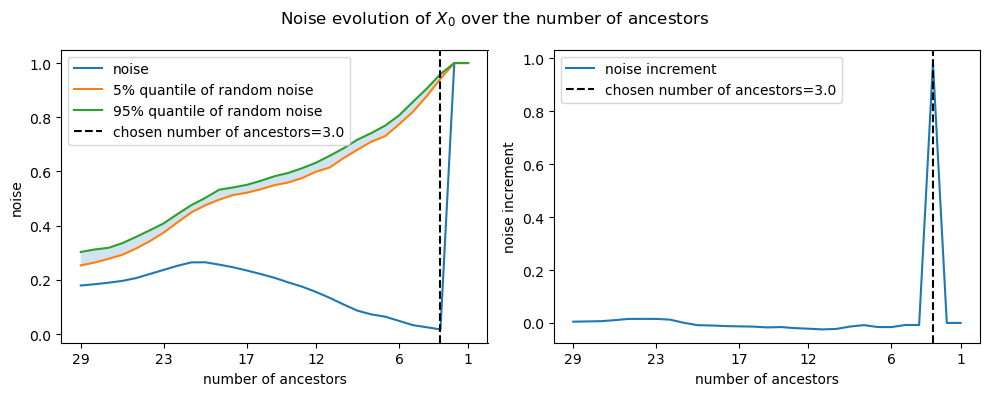


Results for $X_{1}$
Kernel [linear] has n/(n+s)=0.548739159865869, Z=(1.00, 1.00), gamma=7.20e+00
Kernel [quadratic] has n/(n+s)=0.5816585721510626, Z=(0.94, 0.96), gamma=2.33e+00
Kernel [gaussian] has n/(n+s)=0.17981440580791044, Z=(0.25, 0.30), gamma=2.85e+08
$X_{1}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.55)
Ancestors of $X_{1}$: ['$X_{0}$', '$\\ddot{X}_{0}$', '$\\ddot{X}_{1}$']



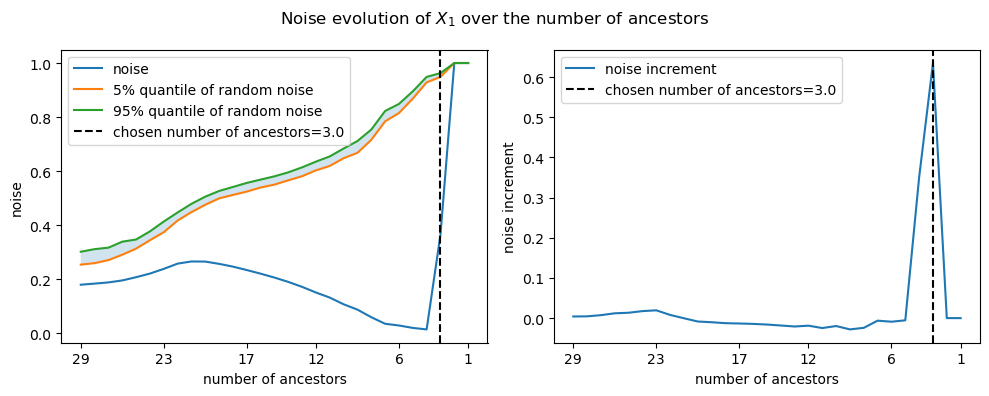


Results for $X_{2}$
Kernel [linear] has n/(n+s)=0.5600441794730538, Z=(1.00, 1.00), gamma=6.82e+00
Kernel [quadratic] has n/(n+s)=0.5920334073198162, Z=(0.94, 0.96), gamma=2.42e+00
Kernel [gaussian] has n/(n+s)=0.18215433118622026, Z=(0.25, 0.30), gamma=2.83e+08
$X_{2}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.56)
Ancestors of $X_{2}$: ['$X_{1}$', '$X_{3}$', '$\\ddot{X}_{2}$']



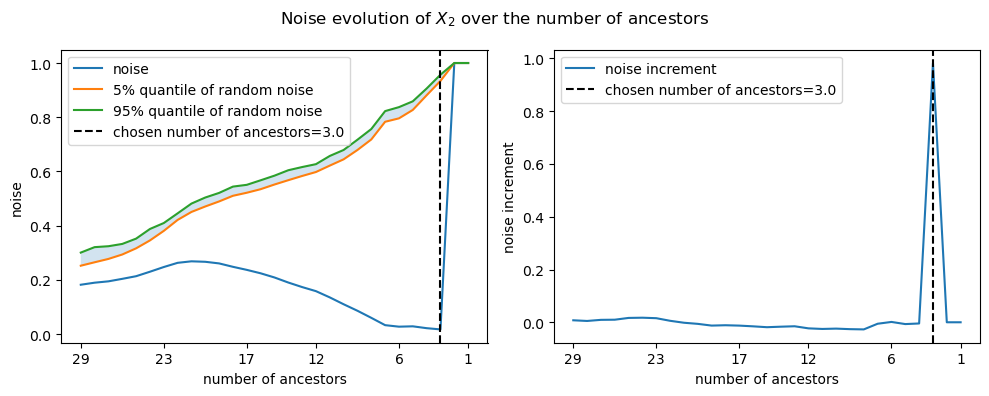


Results for $X_{3}$
Kernel [linear] has n/(n+s)=0.5660721776368938, Z=(1.00, 1.00), gamma=5.81e+00
Kernel [quadratic] has n/(n+s)=0.5889835067783408, Z=(0.94, 0.96), gamma=2.29e+00
Kernel [gaussian] has n/(n+s)=0.18281280689915058, Z=(0.25, 0.30), gamma=2.83e+08
$X_{3}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.57)
Ancestors of $X_{3}$: ['$X_{2}$', '$X_{4}$', '$\\ddot{X}_{3}$']



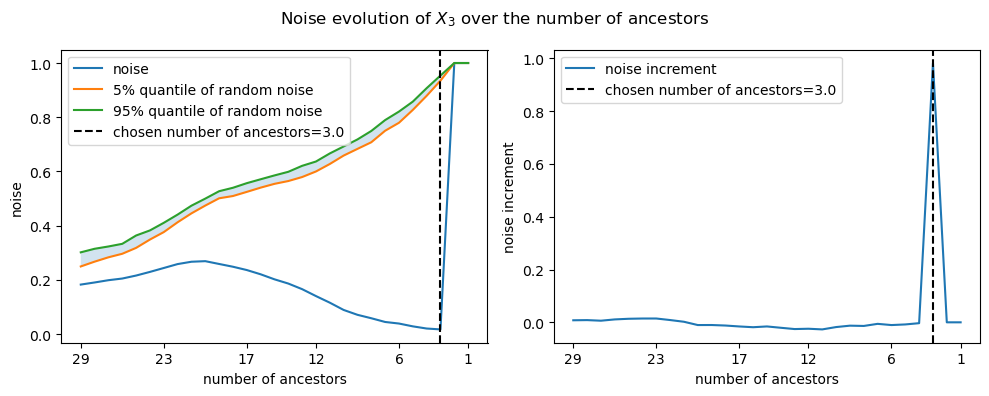


Results for $X_{4}$
Kernel [linear] has n/(n+s)=0.557731099364539, Z=(1.00, 1.00), gamma=7.96e+00
Kernel [quadratic] has n/(n+s)=0.5849459473995152, Z=(0.94, 0.96), gamma=2.79e+00
Kernel [gaussian] has n/(n+s)=0.18340761228111033, Z=(0.25, 0.30), gamma=2.85e+08
$X_{4}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.56)
Ancestors of $X_{4}$: ['$X_{3}$', '$X_{5}$', '$\\ddot{X}_{4}$']



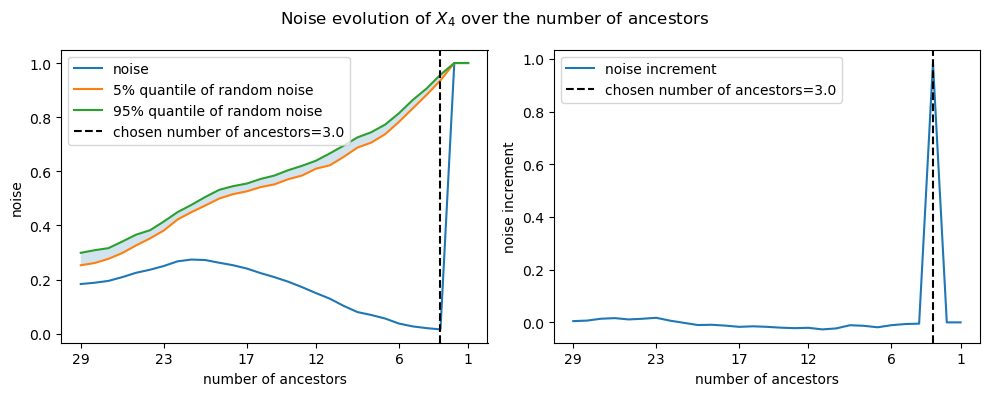


Results for $X_{5}$
Kernel [linear] has n/(n+s)=0.5496714028867064, Z=(1.00, 1.00), gamma=7.83e+00
Kernel [quadratic] has n/(n+s)=0.5712510481713979, Z=(0.94, 0.96), gamma=2.71e+00
Kernel [gaussian] has n/(n+s)=0.18137507717147455, Z=(0.25, 0.30), gamma=2.83e+08
$X_{5}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.55)
Ancestors of $X_{5}$: ['$X_{4}$', '$X_{6}$', '$\\ddot{X}_{5}$']



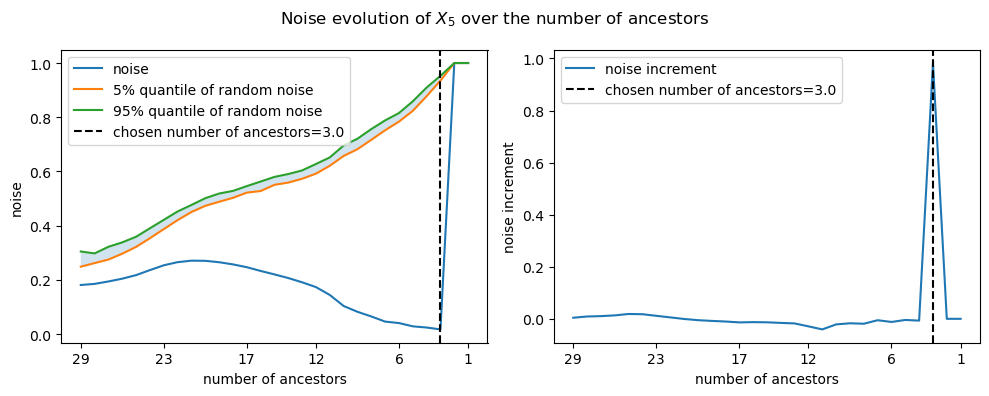


Results for $X_{6}$
Kernel [linear] has n/(n+s)=0.5521810413355986, Z=(1.00, 1.00), gamma=7.27e+00
Kernel [quadratic] has n/(n+s)=0.5925308359481333, Z=(0.94, 0.96), gamma=2.29e+00
Kernel [gaussian] has n/(n+s)=0.18088011997145415, Z=(0.25, 0.30), gamma=2.82e+08
$X_{6}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.55)
Ancestors of $X_{6}$: ['$X_{5}$', '$X_{7}$', '$\\ddot{X}_{6}$']



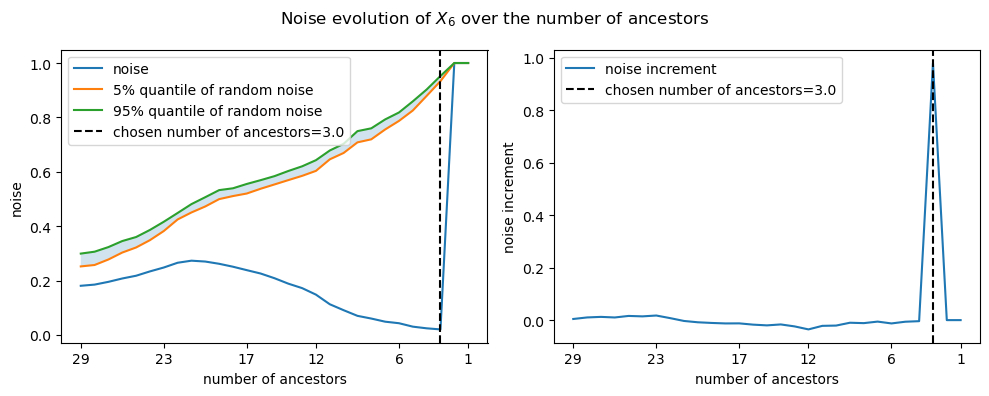


Results for $X_{7}$
Kernel [linear] has n/(n+s)=0.5608841563723184, Z=(1.00, 1.00), gamma=6.23e+00
Kernel [quadratic] has n/(n+s)=0.5959415314152416, Z=(0.94, 0.96), gamma=1.98e+00
Kernel [gaussian] has n/(n+s)=0.1804371024431603, Z=(0.25, 0.30), gamma=2.86e+08
$X_{7}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.56)
Ancestors of $X_{7}$: ['$X_{6}$', '$X_{8}$', '$\\ddot{X}_{7}$']



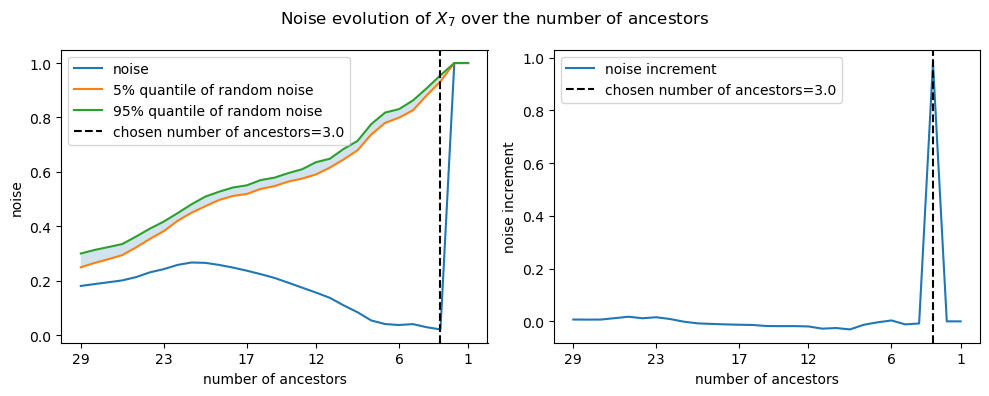


Results for $X_{8}$
Kernel [linear] has n/(n+s)=0.5194110513843111, Z=(1.00, 1.00), gamma=6.45e+00
Kernel [quadratic] has n/(n+s)=0.5315739584301117, Z=(0.94, 0.96), gamma=1.81e+00
Kernel [gaussian] has n/(n+s)=0.18286445056552164, Z=(0.25, 0.30), gamma=2.87e+08
$X_{8}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.52)
Ancestors of $X_{8}$: ['$X_{9}$', '$\\ddot{X}_{8}$', '$\\ddot{X}_{9}$']



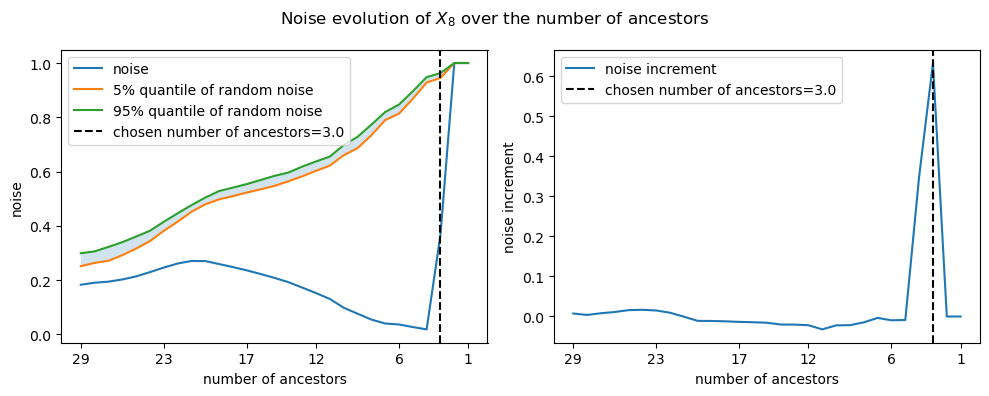


Results for $X_{9}$
Kernel [linear] has n/(n+s)=0.5702029453443259, Z=(1.00, 1.00), gamma=4.02e+00
Kernel [quadratic] has n/(n+s)=0.5914928405389502, Z=(0.95, 0.96), gamma=1.22e+00
Kernel [gaussian] has n/(n+s)=0.17976076574717278, Z=(0.25, 0.30), gamma=2.83e+08
$X_{9}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.57)
Ancestors of $X_{9}$: ['$X_{8}$', '$\\ddot{X}_{8}$', '$\\ddot{X}_{9}$']



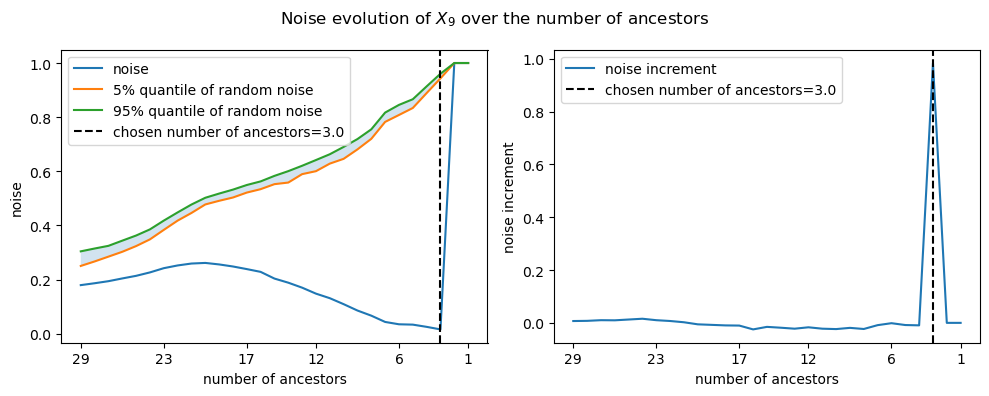


Results for $\dot{X}_{0}$
Kernel [linear] has n/(n+s)=0.8861983898371849, Z=(0.99, 1.00), gamma=5.58e+02
Kernel [quadratic] has n/(n+s)=0.8607871079776817, Z=(0.96, 0.97), gamma=3.00e+02
Kernel [gaussian] has n/(n+s)=0.20498461592066164, Z=(0.26, 0.31), gamma=2.93e+08
$\dot{X}_{0}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.89)
Ancestors of $\dot{X}_{0}$: ['$X_{2}$', '$X_{5}$', '$X_{9}$', '$\\dot{X}_{1}$']



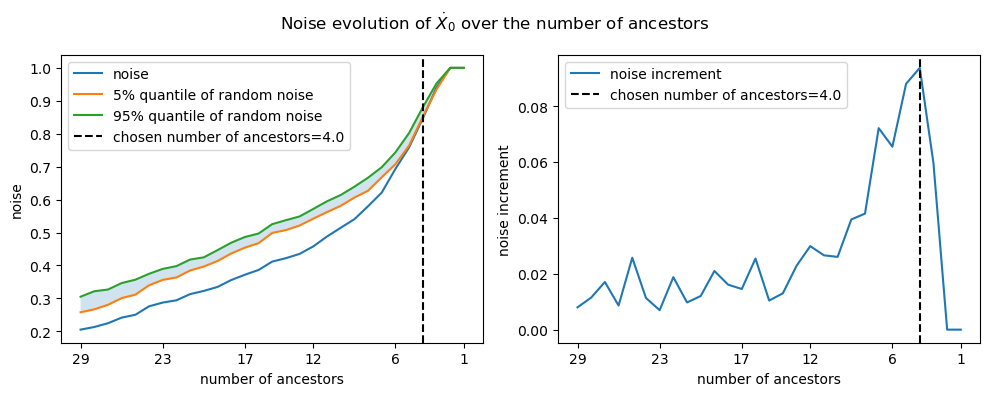


Results for $\dot{X}_{1}$
Kernel [linear] has n/(n+s)=0.807294817085284, Z=(1.00, 1.00), gamma=3.45e+02
Kernel [quadratic] has n/(n+s)=0.8060388574084327, Z=(0.96, 0.97), gamma=1.73e+02
Kernel [gaussian] has n/(n+s)=0.19418936405125437, Z=(0.26, 0.30), gamma=2.89e+08
$\dot{X}_{1}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.81)
Ancestors of $\dot{X}_{1}$: ['$X_{5}$', '$\\dot{X}_{0}$', '$\\dot{X}_{2}$', '$\\dot{X}_{3}$']



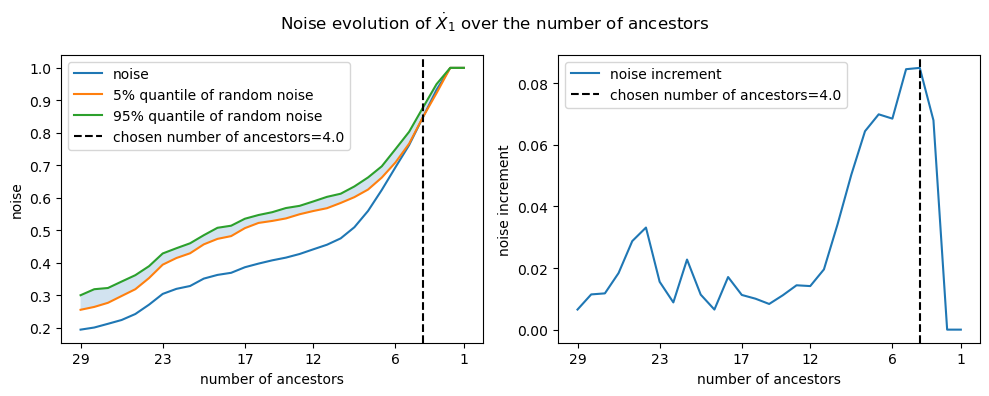


Results for $\dot{X}_{2}$
Kernel [linear] has n/(n+s)=0.7724834103589188, Z=(1.00, 1.00), gamma=3.11e+02
Kernel [quadratic] has n/(n+s)=0.7726410486426557, Z=(0.96, 0.97), gamma=1.51e+02
Kernel [gaussian] has n/(n+s)=0.19411119078296973, Z=(0.25, 0.30), gamma=2.88e+08
$\dot{X}_{2}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.77)
Ancestors of $\dot{X}_{2}$: ['$X_{5}$', '$\\dot{X}_{0}$', '$\\dot{X}_{1}$', '$\\dot{X}_{3}$', '$\\dot{X}_{4}$']



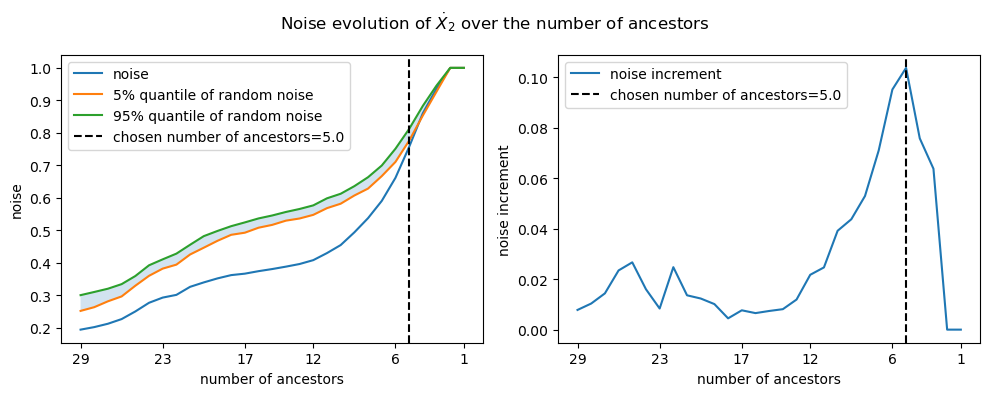


Results for $\dot{X}_{3}$
Kernel [linear] has n/(n+s)=0.7517986548504441, Z=(1.00, 1.00), gamma=2.87e+02
Kernel [quadratic] has n/(n+s)=0.7473905168879584, Z=(0.96, 0.97), gamma=1.40e+02
Kernel [gaussian] has n/(n+s)=0.19332086372968663, Z=(0.25, 0.30), gamma=2.87e+08
$\dot{X}_{3}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.75)
Ancestors of $\dot{X}_{3}$: ['$X_{0}$', '$\\dot{X}_{1}$', '$\\dot{X}_{2}$', '$\\dot{X}_{4}$', '$\\dot{X}_{5}$', '$\\ddot{X}_{2}$']



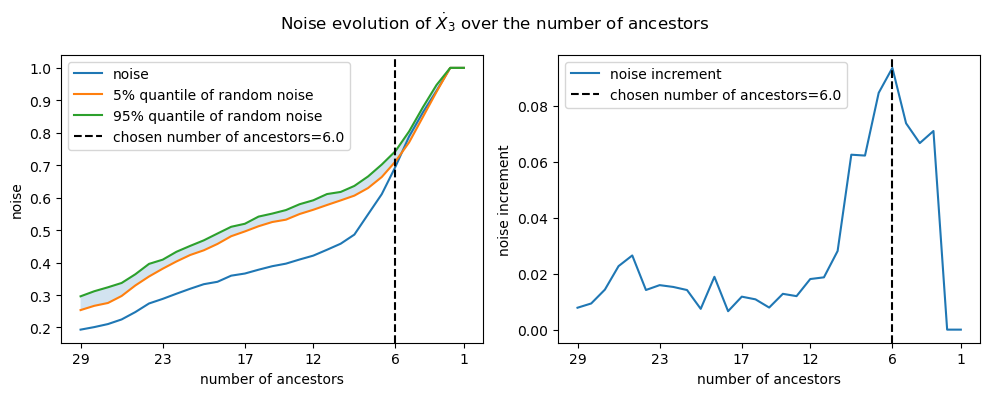


Results for $\dot{X}_{4}$
Kernel [linear] has n/(n+s)=0.7417779302255731, Z=(1.00, 1.00), gamma=2.60e+02
Kernel [quadratic] has n/(n+s)=0.7457679258129214, Z=(0.96, 0.97), gamma=1.28e+02
Kernel [gaussian] has n/(n+s)=0.1940205929790347, Z=(0.25, 0.31), gamma=2.84e+08
$\dot{X}_{4}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.74)
Ancestors of $\dot{X}_{4}$: ['$X_{5}$', '$\\dot{X}_{2}$', '$\\dot{X}_{3}$', '$\\dot{X}_{5}$', '$\\ddot{X}_{0}$']



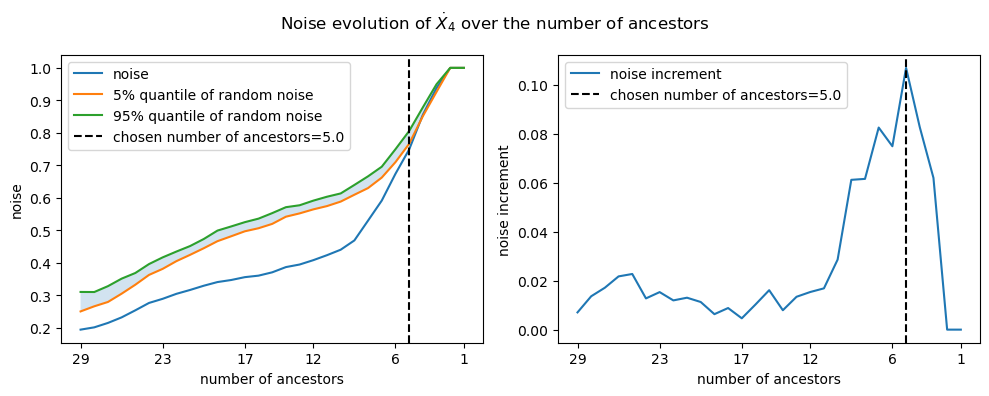


Results for $\dot{X}_{5}$
Kernel [linear] has n/(n+s)=0.7481323076611321, Z=(1.00, 1.00), gamma=2.69e+02
Kernel [quadratic] has n/(n+s)=0.7327583084797503, Z=(0.96, 0.97), gamma=1.30e+02
Kernel [gaussian] has n/(n+s)=0.19469744543612974, Z=(0.25, 0.30), gamma=2.85e+08
$\dot{X}_{5}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.75)
Ancestors of $\dot{X}_{5}$: ['$X_{6}$', '$X_{7}$', '$\\dot{X}_{3}$', '$\\dot{X}_{4}$', '$\\dot{X}_{6}$', '$\\ddot{X}_{0}$']



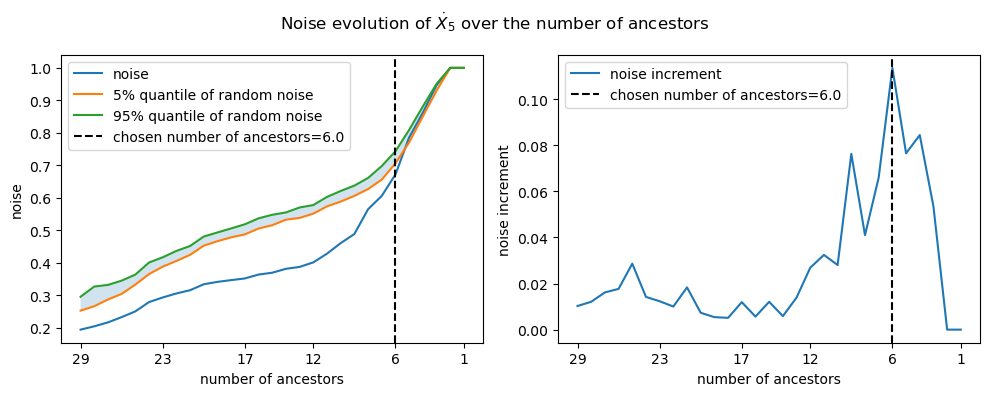


Results for $\dot{X}_{6}$
Kernel [linear] has n/(n+s)=0.7571233613141952, Z=(1.00, 1.00), gamma=2.79e+02
Kernel [quadratic] has n/(n+s)=0.7397846092299701, Z=(0.96, 0.97), gamma=1.36e+02
Kernel [gaussian] has n/(n+s)=0.19371399760286062, Z=(0.25, 0.30), gamma=2.89e+08
$\dot{X}_{6}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.76)
Ancestors of $\dot{X}_{6}$: ['$X_{2}$', '$X_{5}$', '$\\dot{X}_{5}$', '$\\dot{X}_{7}$', '$\\ddot{X}_{1}$']



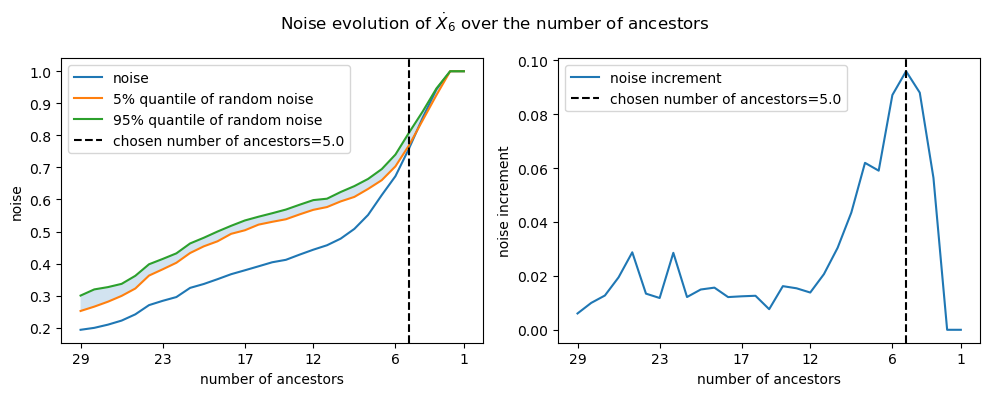


Results for $\dot{X}_{7}$
Kernel [linear] has n/(n+s)=0.7609972787807064, Z=(1.00, 1.00), gamma=2.75e+02
Kernel [quadratic] has n/(n+s)=0.7512655312977257, Z=(0.96, 0.97), gamma=1.35e+02
Kernel [gaussian] has n/(n+s)=0.1904492709388446, Z=(0.25, 0.30), gamma=2.87e+08
$\dot{X}_{7}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.76)
Ancestors of $\dot{X}_{7}$: ['$X_{2}$', '$X_{7}$', '$X_{8}$', '$\\dot{X}_{5}$', '$\\dot{X}_{6}$', '$\\dot{X}_{8}$']



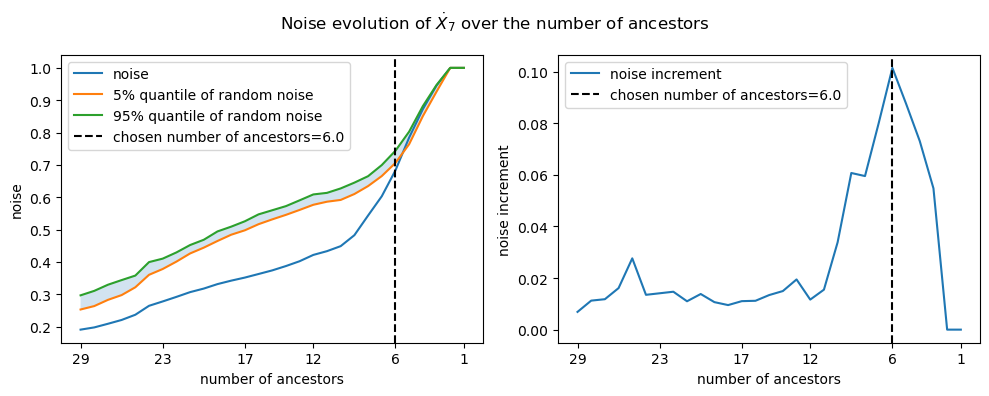


Results for $\dot{X}_{8}$
Kernel [linear] has n/(n+s)=0.7944186498783923, Z=(1.00, 1.00), gamma=3.02e+02
Kernel [quadratic] has n/(n+s)=0.7811779694203911, Z=(0.96, 0.97), gamma=1.53e+02
Kernel [gaussian] has n/(n+s)=0.190079422510827, Z=(0.25, 0.30), gamma=2.87e+08
$\dot{X}_{8}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.79)
Ancestors of $\dot{X}_{8}$: ['$X_{6}$', '$X_{8}$', '$\\dot{X}_{7}$', '$\\dot{X}_{9}$', '$\\ddot{X}_{2}$']



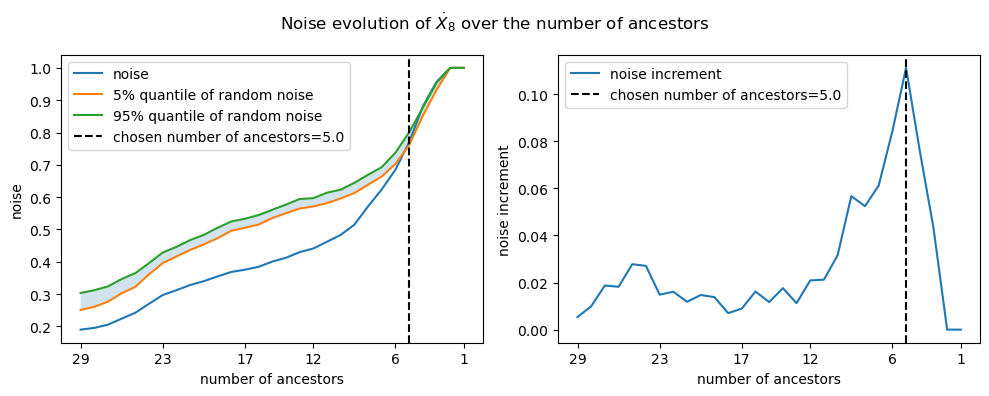


Results for $\dot{X}_{9}$
Kernel [linear] has n/(n+s)=0.8728281628522944, Z=(1.00, 1.00), gamma=5.28e+02
Kernel [quadratic] has n/(n+s)=0.8367534233753438, Z=(0.96, 0.97), gamma=2.81e+02
Kernel [gaussian] has n/(n+s)=0.19853972488619628, Z=(0.25, 0.30), gamma=2.87e+08
$\dot{X}_{9}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.87)
Ancestors of $\dot{X}_{9}$: ['$X_{0}$', '$X_{4}$', '$X_{9}$', '$\\dot{X}_{2}$', '$\\dot{X}_{7}$', '$\\dot{X}_{8}$']



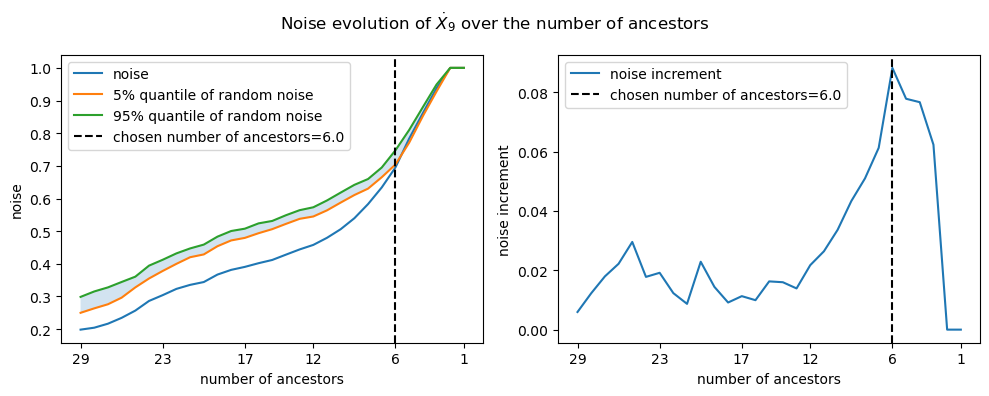


Results for $\ddot{X}_{0}$
Kernel [linear] has n/(n+s)=0.7202112296884599, Z=(1.00, 1.00), gamma=3.75e+00
Kernel [quadratic] has n/(n+s)=0.7088391677112735, Z=(0.95, 0.96), gamma=1.28e+00
Kernel [gaussian] has n/(n+s)=0.16978385865641152, Z=(0.25, 0.30), gamma=2.84e+08
$\ddot{X}_{0}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.72)
Ancestors of $\ddot{X}_{0}$: ['$X_{0}$', '$X_{1}$', '$\\ddot{X}_{1}$']



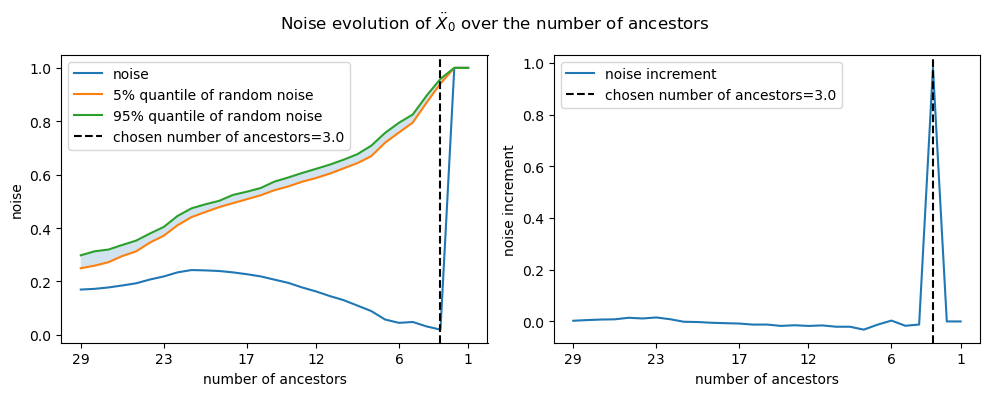


Results for $\ddot{X}_{1}$
Kernel [linear] has n/(n+s)=0.7734809144778246, Z=(1.00, 1.00), gamma=9.57e+00
Kernel [quadratic] has n/(n+s)=0.7573507221575089, Z=(0.94, 0.96), gamma=3.40e+00
Kernel [gaussian] has n/(n+s)=0.16703142814934765, Z=(0.25, 0.30), gamma=2.81e+08
$\ddot{X}_{1}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.77)
Ancestors of $\ddot{X}_{1}$: ['$X_{1}$', '$X_{2}$', '$\\ddot{X}_{0}$']



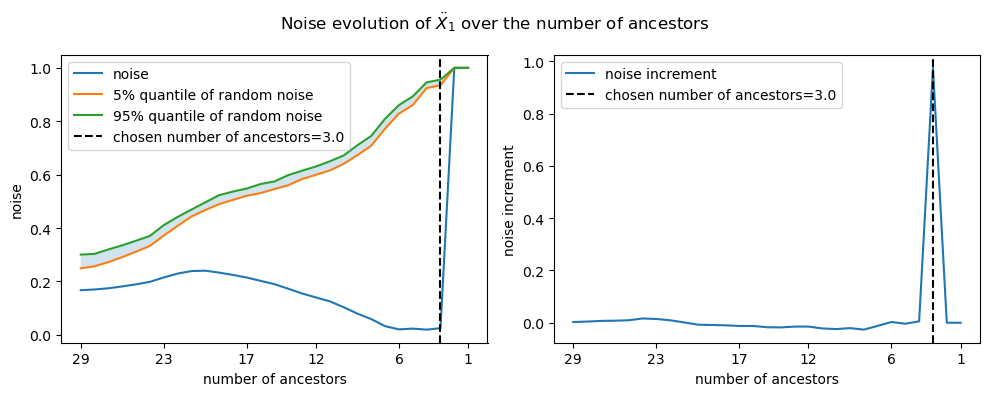


Results for $\ddot{X}_{2}$
Kernel [linear] has n/(n+s)=0.7288635766820577, Z=(1.00, 1.00), gamma=8.02e+00
Kernel [quadratic] has n/(n+s)=0.7110660725601344, Z=(0.94, 0.96), gamma=3.05e+00
Kernel [gaussian] has n/(n+s)=0.16913414417640515, Z=(0.25, 0.30), gamma=2.79e+08
$\ddot{X}_{2}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.73)
Ancestors of $\ddot{X}_{2}$: ['$X_{1}$', '$X_{2}$', '$X_{3}$']



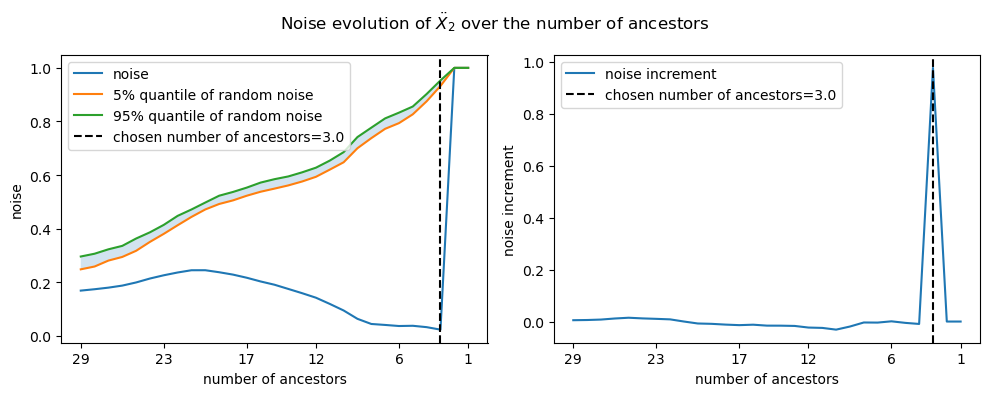


Results for $\ddot{X}_{3}$
Kernel [linear] has n/(n+s)=0.7188352528595625, Z=(1.00, 1.00), gamma=6.54e+00
Kernel [quadratic] has n/(n+s)=0.7074946770521312, Z=(0.94, 0.96), gamma=2.74e+00
Kernel [gaussian] has n/(n+s)=0.17144004781942127, Z=(0.25, 0.30), gamma=2.81e+08
$\ddot{X}_{3}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.72)
Ancestors of $\ddot{X}_{3}$: ['$X_{2}$', '$X_{3}$', '$X_{4}$']



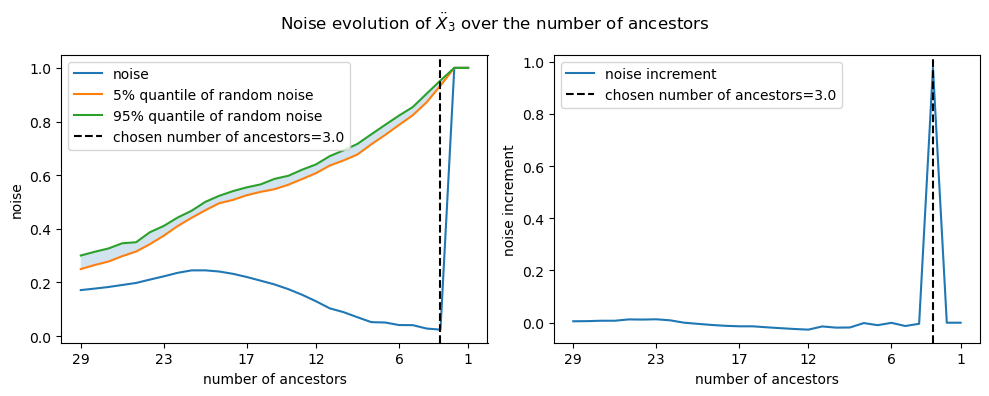


Results for $\ddot{X}_{4}$
Kernel [linear] has n/(n+s)=0.7446406596596812, Z=(1.00, 1.00), gamma=1.02e+01
Kernel [quadratic] has n/(n+s)=0.7253901851176685, Z=(0.94, 0.96), gamma=3.89e+00
Kernel [gaussian] has n/(n+s)=0.1731443919777903, Z=(0.25, 0.31), gamma=2.84e+08
$\ddot{X}_{4}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.74)
Ancestors of $\ddot{X}_{4}$: ['$X_{3}$', '$X_{4}$', '$X_{5}$']



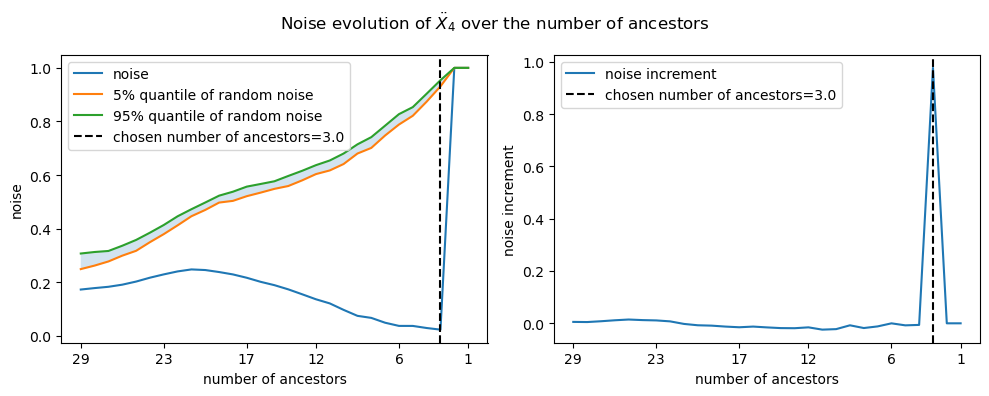


Results for $\ddot{X}_{5}$
Kernel [linear] has n/(n+s)=0.7481424272952211, Z=(1.00, 1.00), gamma=7.28e+00
Kernel [quadratic] has n/(n+s)=0.7195803777595967, Z=(0.94, 0.96), gamma=2.44e+00
Kernel [gaussian] has n/(n+s)=0.16813483214655944, Z=(0.25, 0.30), gamma=2.80e+08
$\ddot{X}_{5}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.75)
Ancestors of $\ddot{X}_{5}$: ['$X_{4}$', '$X_{5}$', '$X_{6}$']



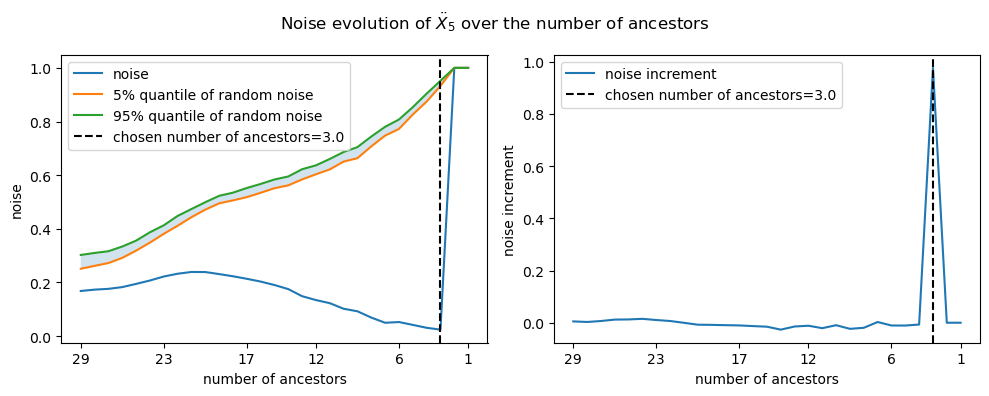


Results for $\ddot{X}_{6}$
Kernel [linear] has n/(n+s)=0.7492646865297901, Z=(1.00, 1.00), gamma=7.99e+00
Kernel [quadratic] has n/(n+s)=0.7289290313941097, Z=(0.94, 0.96), gamma=2.86e+00
Kernel [gaussian] has n/(n+s)=0.16866431190172018, Z=(0.25, 0.30), gamma=2.80e+08
$\ddot{X}_{6}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.75)
Ancestors of $\ddot{X}_{6}$: ['$X_{5}$', '$X_{6}$', '$X_{7}$']



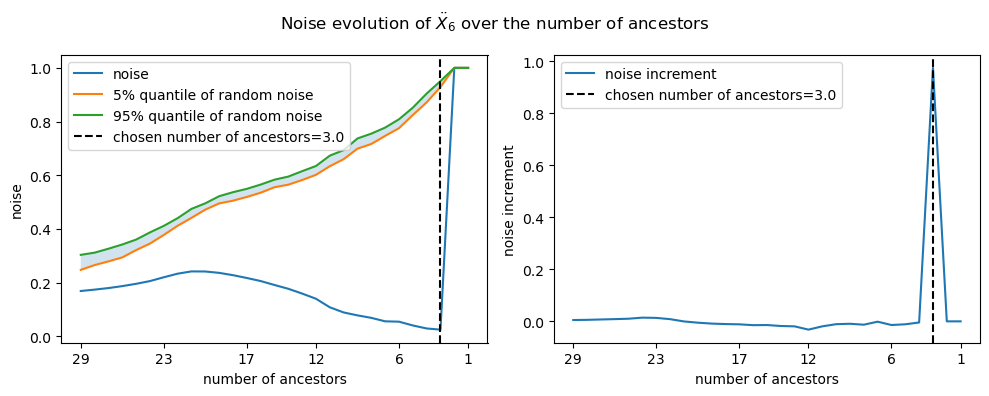


Results for $\ddot{X}_{7}$
Kernel [linear] has n/(n+s)=0.7378738614399647, Z=(1.00, 1.00), gamma=6.35e+00
Kernel [quadratic] has n/(n+s)=0.704367244644096, Z=(0.94, 0.96), gamma=2.16e+00
Kernel [gaussian] has n/(n+s)=0.16933475147519905, Z=(0.25, 0.30), gamma=2.85e+08
$\ddot{X}_{7}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.74)
Ancestors of $\ddot{X}_{7}$: ['$X_{6}$', '$X_{7}$', '$X_{8}$']



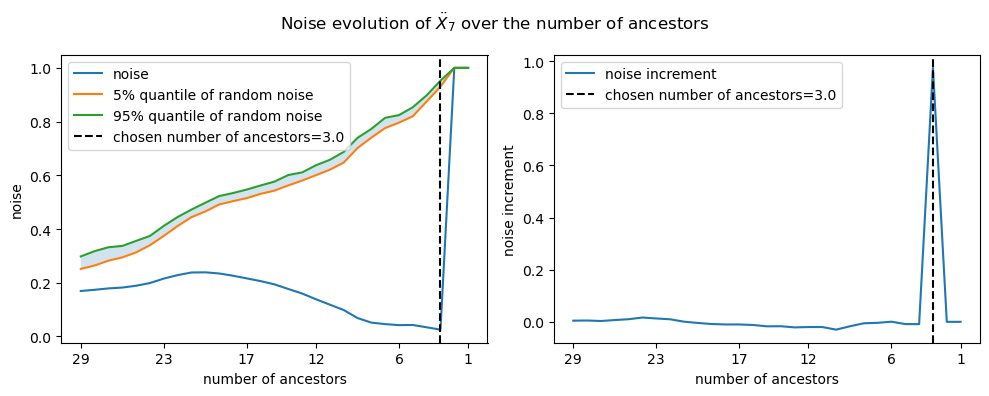


Results for $\ddot{X}_{8}$
Kernel [linear] has n/(n+s)=0.7861619265220101, Z=(1.00, 1.00), gamma=8.24e+00
Kernel [quadratic] has n/(n+s)=0.7620452091787788, Z=(0.94, 0.96), gamma=2.94e+00
Kernel [gaussian] has n/(n+s)=0.16891912908847026, Z=(0.25, 0.30), gamma=2.84e+08
$\ddot{X}_{8}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.79)
Ancestors of $\ddot{X}_{8}$: ['$X_{7}$', '$X_{8}$', '$\\ddot{X}_{9}$']



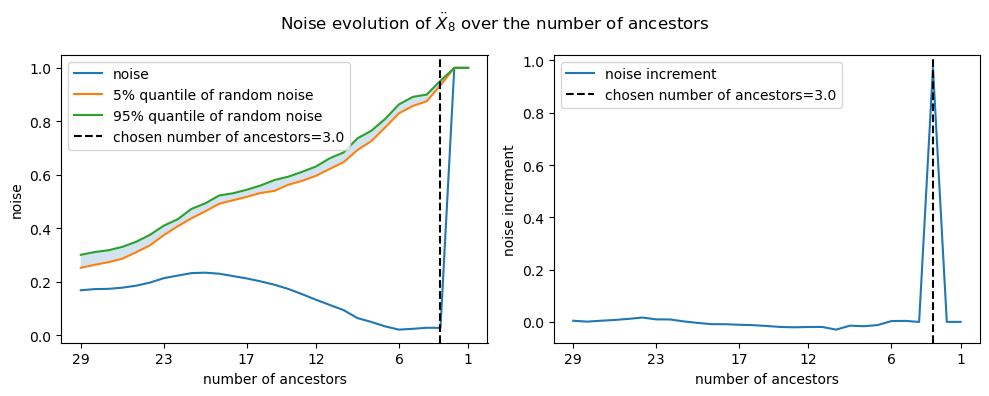


Results for $\ddot{X}_{9}$
Kernel [linear] has n/(n+s)=0.7009500807394811, Z=(1.00, 1.00), gamma=3.32e+00
Kernel [quadratic] has n/(n+s)=0.6919175069911657, Z=(0.95, 0.96), gamma=1.07e+00
Kernel [gaussian] has n/(n+s)=0.17229064545929207, Z=(0.25, 0.30), gamma=2.82e+08
$\ddot{X}_{9}$ has ancestors with the kernel [gaussian] | (n/(s+n)=0.70)
Ancestors of $\ddot{X}_{9}$: ['$X_{8}$', '$X_{9}$', '$\\ddot{X}_{8}$']



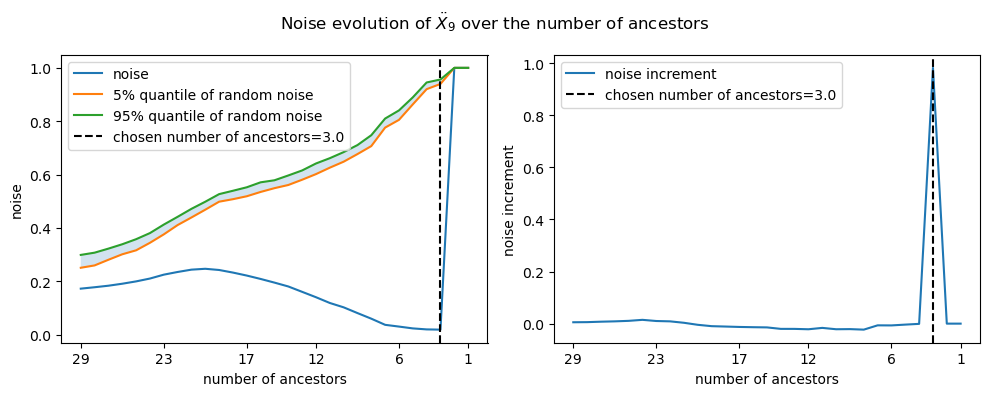

In [ ]:
graph_discovery_non_linear.fit()

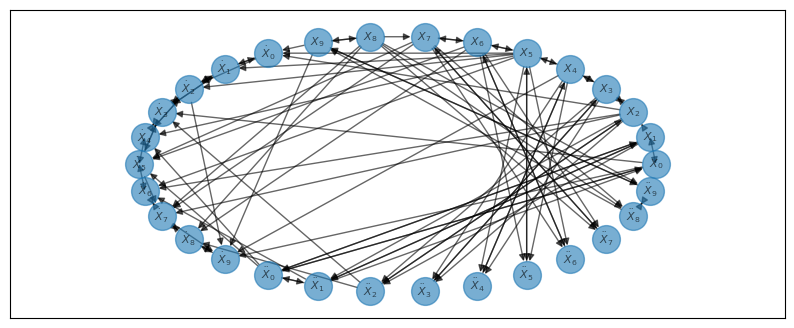

In [ ]:
graph_discovery_non_linear.plot_graph(type_label=False)

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1549691/56301188.py:11: SyntaxWarning: invalid escape sequence '\d'
  G2=nx.subgraph(graph_discovery_non_linear.G,[x for x in graph_discovery.G.nodes() if '\dot' not in x])


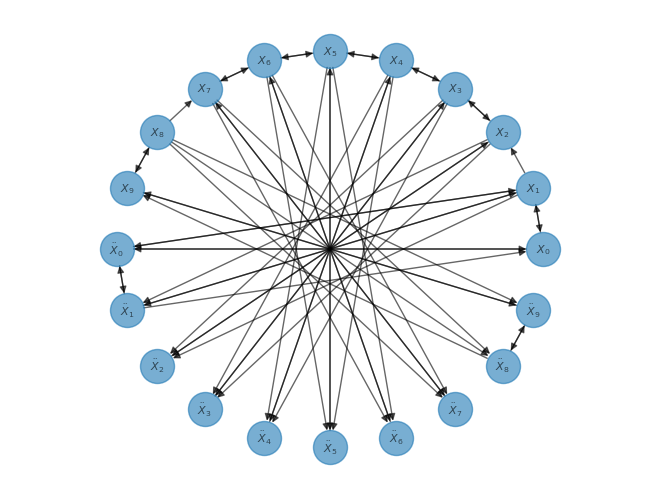

In [ ]:
def plot_a_network(G,type_label=True):
    pos=nx.kamada_kawai_layout(G, G.nodes())
    nx.draw(G, with_labels=True, pos=pos, node_size=600, font_size=8, alpha=0.6)
    if type_label:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'type'))
    x_values, y_values = zip(*pos.values())
    x_max = max(x_values)
    x_min = min(x_values)
    x_margin = (x_max - x_min) * 0.25
    plt.xlim(x_min - x_margin, x_max + x_margin)
G2=nx.subgraph(graph_discovery_non_linear.G,[x for x in graph_discovery.G.nodes() if '\dot' not in x])
plot_a_network(G2,type_label=False)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1549691/2000600593.py:1: SyntaxWarning: invalid escape sequence '\d'
  plot_a_network(nx.ego_graph(G2.reverse(),'$\ddot{X}_{1}$',undirected=False,radius=1).reverse(),type_label=True)


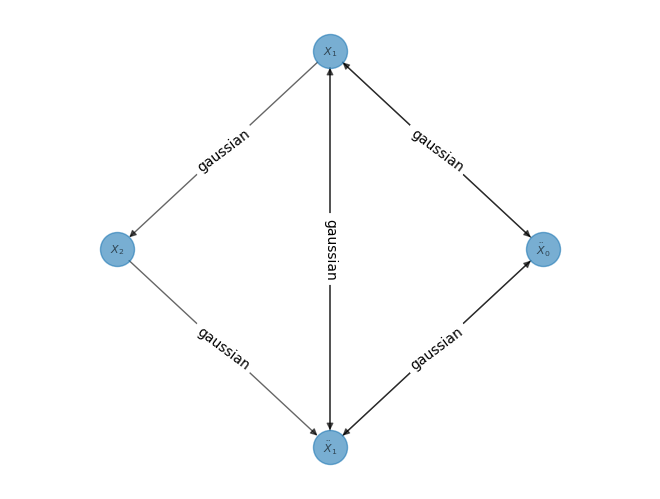

In [ ]:
plot_a_network(nx.ego_graph(G2.reverse(),'$\ddot{X}_{1}$',undirected=False,radius=1).reverse(),type_label=True)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1549691/1177259404.py:1: SyntaxWarning: invalid escape sequence '\d'
  plot_a_network(nx.ego_graph(graph_discovery.G.reverse(),'$\dot{X}_{5}$',undirected=False,radius=1).reverse(),type_label=False)


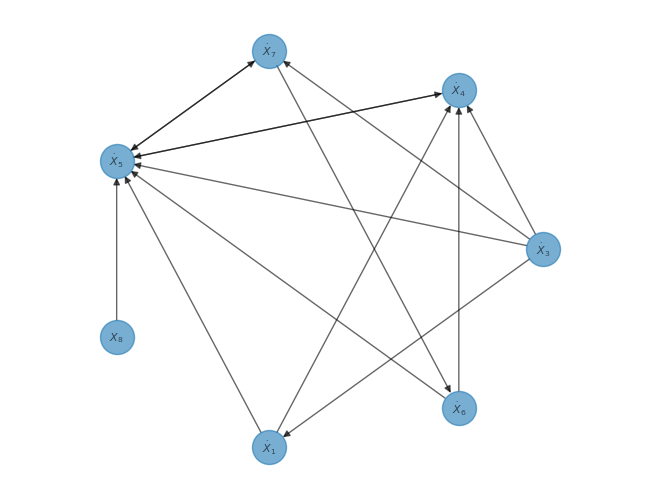

In [ ]:
plot_a_network(nx.ego_graph(graph_discovery.G.reverse(),'$\dot{X}_{5}$',undirected=False,radius=1).reverse(),type_label=False)